<a href="https://colab.research.google.com/github/Prisci723/ia2/blob/main/Laboratorio2/Laboratorio_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset plantas medicinales
En este dataset se entrenará un modelo utilizando las plantas
  * Aloe Vera
  * Cedron
  * Floripondio
  * Higuera
  * Níspero

  Se utilizará pytorch para su entrenamiento






  Lo primero que hacemos es importar las librerías necesarias

In [1]:
# Importamos las librerias

import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random
from sklearn.model_selection import train_test_split

Importamos google drive para poder cargar las imágenes

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dentro de la carpeta de drive se encuentra el dataset cargado en una carpeta, dicha carpeta contiene dentro de sí 5 carpetas con sus imágenes correspondientes.

El siguiente código nos permite cargar las imágenes y etiquetarlas según el orden alfabético que tengan el nombre de las carpetas, es decir que
* Aloe Vera ---> 0
* Cedron --> 1
* Floripondio --> 2
* Higuera --> 3
* Nispero --> 4


Abrir imagen: Para cada archivo de imagen encontrado, lo abrimos utilizando la biblioteca PIL (Image.open).
Convertir a RGB: Convertimos la imagen a modo RGB para asegurarnos de que todas las imágenes tengan el mismo formato de color.
Normalización: Convertimos la imagen a un array de NumPy y normalizamos los valores de píxel dividiendo por 255.0 para que estén en el rango [0, 1]. Esto es importante para estandarizar los datos antes de ingresarlos a la red neuronal.
Redimensionar: Cambiamos el tamaño de la imagen a un tamaño fijo ( 50x50 píxeles) para que todas las imágenes tengan el mismo tamaño de entrada. Esto es crucial para poder entrenar un modelo, ya que la mayoría de los modelos de aprendizaje automático requieren que todas las entradas tengan el mismo tamaño.

In [12]:
def cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0
                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset

In [13]:
trainset = cargar_dataset_train('/content/drive/MyDrive/SIS421/SIS421 prueba dataset 1')

print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
# print("Número de ejemplos en el conjunto de prueba:", len(testset))

Número de ejemplos en el conjunto de entrenamiento: 11158


In [14]:
# Ejemplo de cómo definir la lista de clases
classes = ['Aloe Vera', 'Cedron', 'Floripondio', 'Higuera', 'Nispero']

Aquí podemos observar como las imágenes son redimensionadas y cuentan con su etiqueta correspondiente

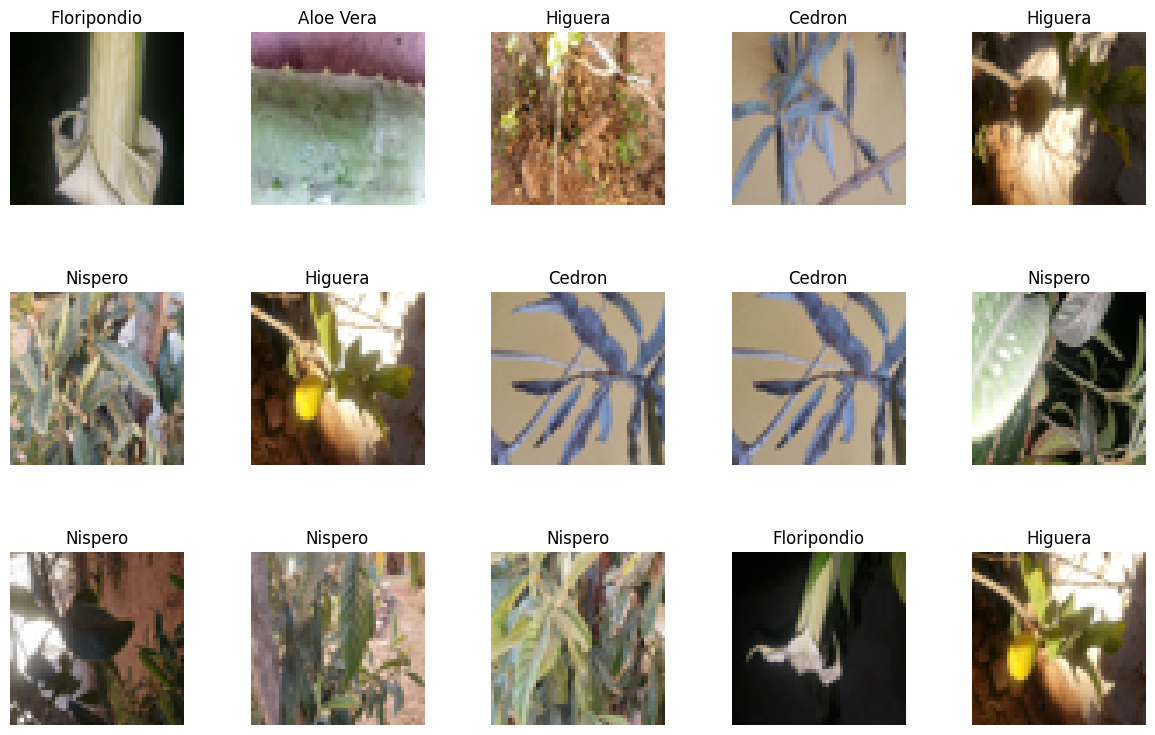

In [15]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        #print(label)
        #clase_index = classes.index(clase)
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [16]:
# Convertir las imágenes y etiquetas a arrays de NumPy
images = np.array([np.array(img) for img, label in trainset])
labels = np.array([label for img, label in trainset])

# Dividir los datos en 85% entrenamiento y 15% prueba
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.15, random_state=42
)

# Opcional: convertir nuevamente a arrays de NumPy si necesitas
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [17]:
# ver número de imágenes, resolución y número de canales
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((9484, 50, 50, 3), (1674, 50, 50, 3), (9484,), (1674,))

In [18]:
# tipo de datos
train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int64'))

Una vez que las imágenes han sido preprocesadas, es que se utiliza el objeto dataset que nos permitirá colocar las imágenes en un formato que Pytorch pueda trabajarlas

In [19]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Verifica si self.image_paths[idx] es una ruta o un numpy.ndarray
        if isinstance(self.image_paths[idx], str):
            # Si es una ruta, abre la imagen
            image = Image.open(self.image_paths[idx]).convert('RGB')
        elif isinstance(self.image_paths[idx], np.ndarray):
            # Si ya es un numpy.ndarray, conviértelo directamente a imagen PIL
            image = Image.fromarray(self.image_paths[idx])

        # Aplica transformaciones si se proporcionan
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label


In [20]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Definir las transformaciones para las imágenes (opcional)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar imágenes a 32x32
    transforms.ToTensor()         # Convertir imágenes a tensores
])

# Crear el dataset de entrenamiento y de prueba
train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)

# Crear los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Normalizamos los datos antes de preprocesarlos, y tmbién serán normalizados antes de entrar en la donde se obtienen los pesos

In [21]:
def build_model(D_in=32*32*3, H=100, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

El dataloader lo que nos permitirá será cargar los datos en batches que puedan ser manejador de forma más eficiente por el GPU

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def fit(model, dataloader, epochs=1000, checkpoint_interval=20, save_path='/content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])  # Asegúrate de acceder a la clave 'train'
        for X, y in bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X.view(X.size(0), -1))  # Aplanar imágenes
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        model.eval()
        val_loss, val_acc = [], []
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for X, y in bar:
                X, y = X.to(device), y.to(device)
                y_hat = model(X.view(X.size(0), -1))
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        if epoch % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': np.mean(val_loss),
            }, save_path)
            print(f"Checkpoint guardado en {save_path} (Epoch {epoch})")



In [23]:

# Definir el dispositivo a utilizar (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Construir el modelo
model = build_model(D_in=32*32*3, H=100, D_out=len(set(train_labels)))
model.to(device)  # Mover el modelo al dispositivo


Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=5, bias=True)
)

In [ ]:
# Entrenar el modelo
fit(model, {'train': train_loader, 'test': test_loader}, epochs=1000, checkpoint_interval=20, save_path='/content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth')


val_loss 0.28984 val_acc 0.89328: 100%|██████████| 53/53 [00:00<00:00, 72.22it/s]


Epoch 1/1000 loss 0.31820 val_loss 0.28984 acc 0.90832 val_acc 0.89328


val_loss 0.66245 val_acc 0.75248: 100%|██████████| 53/53 [00:00<00:00, 66.74it/s]


Epoch 2/1000 loss 0.08493 val_loss 0.66245 acc 0.97678 val_acc 0.75248


val_loss 1.47109 val_acc 0.64363: 100%|██████████| 53/53 [00:01<00:00, 45.27it/s]


Epoch 3/1000 loss 0.05271 val_loss 1.47109 acc 0.98495 val_acc 0.64363


val_loss 0.32961 val_acc 0.87606: 100%|██████████| 53/53 [00:00<00:00, 61.81it/s]


Epoch 4/1000 loss 0.03700 val_loss 0.32961 acc 0.98853 val_acc 0.87606


val_loss 0.05097 val_acc 0.98231: 100%|██████████| 53/53 [00:00<00:00, 65.40it/s]


Epoch 5/1000 loss 0.02907 val_loss 0.05097 acc 0.99137 val_acc 0.98231


val_loss 0.08470 val_acc 0.96757: 100%|██████████| 53/53 [00:01<00:00, 39.45it/s]


Epoch 6/1000 loss 0.02849 val_loss 0.08470 acc 0.99074 val_acc 0.96757


val_loss 0.01332 val_acc 0.99705: 100%|██████████| 53/53 [00:00<00:00, 66.67it/s]


Epoch 7/1000 loss 0.01932 val_loss 0.01332 acc 0.99383 val_acc 0.99705


val_loss 0.03763 val_acc 0.98939: 100%|██████████| 53/53 [00:00<00:00, 65.11it/s]


Epoch 8/1000 loss 0.01525 val_loss 0.03763 acc 0.99569 val_acc 0.98939


val_loss 0.02731 val_acc 0.99057: 100%|██████████| 53/53 [00:01<00:00, 41.47it/s]


Epoch 9/1000 loss 0.02239 val_loss 0.02731 acc 0.99274 val_acc 0.99057


val_loss 0.00917 val_acc 0.99705: 100%|██████████| 53/53 [00:00<00:00, 60.45it/s]


Epoch 10/1000 loss 0.01249 val_loss 0.00917 acc 0.99663 val_acc 0.99705


val_loss 0.02251 val_acc 0.99469: 100%|██████████| 53/53 [00:00<00:00, 60.90it/s]


Epoch 11/1000 loss 0.02060 val_loss 0.02251 acc 0.99365 val_acc 0.99469


val_loss 0.02332 val_acc 0.99410: 100%|██████████| 53/53 [00:01<00:00, 40.32it/s]


Epoch 12/1000 loss 0.01696 val_loss 0.02332 acc 0.99509 val_acc 0.99410


val_loss 0.03690 val_acc 0.98762: 100%|██████████| 53/53 [00:00<00:00, 63.07it/s]


Epoch 13/1000 loss 0.01431 val_loss 0.03690 acc 0.99400 val_acc 0.98762


val_loss 0.05836 val_acc 0.98054: 100%|██████████| 53/53 [00:00<00:00, 64.48it/s]


Epoch 14/1000 loss 0.00999 val_loss 0.05836 acc 0.99779 val_acc 0.98054


val_loss 0.10902 val_acc 0.95814: 100%|██████████| 53/53 [00:01<00:00, 45.94it/s]


Epoch 15/1000 loss 0.01285 val_loss 0.10902 acc 0.99558 val_acc 0.95814


val_loss 0.07289 val_acc 0.97818: 100%|██████████| 53/53 [00:00<00:00, 66.43it/s]


Epoch 16/1000 loss 0.01036 val_loss 0.07289 acc 0.99625 val_acc 0.97818


val_loss 0.01341 val_acc 0.99646: 100%|██████████| 53/53 [00:01<00:00, 49.00it/s]


Epoch 17/1000 loss 0.00773 val_loss 0.01341 acc 0.99779 val_acc 0.99646


val_loss 0.00719 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 61.89it/s]


Epoch 18/1000 loss 0.01084 val_loss 0.00719 acc 0.99632 val_acc 0.99882


val_loss 0.01256 val_acc 0.99410: 100%|██████████| 53/53 [00:00<00:00, 61.68it/s]


Epoch 19/1000 loss 0.01156 val_loss 0.01256 acc 0.99653 val_acc 0.99410


val_loss 0.02712 val_acc 0.98998: 100%|██████████| 53/53 [00:01<00:00, 42.20it/s]


Epoch 20/1000 loss 0.01121 val_loss 0.02712 acc 0.99653 val_acc 0.98998
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 20)


val_loss 0.32991 val_acc 0.91380: 100%|██████████| 53/53 [00:00<00:00, 63.33it/s]


Epoch 21/1000 loss 0.00615 val_loss 0.32991 acc 0.99832 val_acc 0.91380


val_loss 0.00898 val_acc 0.99646: 100%|██████████| 53/53 [00:00<00:00, 62.11it/s]


Epoch 22/1000 loss 0.00841 val_loss 0.00898 acc 0.99712 val_acc 0.99646


val_loss 0.03437 val_acc 0.98821: 100%|██████████| 53/53 [00:01<00:00, 40.79it/s]


Epoch 23/1000 loss 0.00869 val_loss 0.03437 acc 0.99726 val_acc 0.98821


val_loss 0.01506 val_acc 0.99528: 100%|██████████| 53/53 [00:00<00:00, 69.83it/s]


Epoch 24/1000 loss 0.01130 val_loss 0.01506 acc 0.99621 val_acc 0.99528


val_loss 0.03526 val_acc 0.98821: 100%|██████████| 53/53 [00:00<00:00, 61.08it/s]


Epoch 25/1000 loss 0.00934 val_loss 0.03526 acc 0.99684 val_acc 0.98821


val_loss 0.01314 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 38.73it/s]


Epoch 26/1000 loss 0.01124 val_loss 0.01314 acc 0.99632 val_acc 0.99823


val_loss 0.01873 val_acc 0.99410: 100%|██████████| 53/53 [00:00<00:00, 63.42it/s]


Epoch 27/1000 loss 0.00316 val_loss 0.01873 acc 0.99905 val_acc 0.99410


val_loss 0.00486 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 60.12it/s]


Epoch 28/1000 loss 0.00195 val_loss 0.00486 acc 0.99958 val_acc 0.99882


val_loss 0.01334 val_acc 0.99587: 100%|██████████| 53/53 [00:01<00:00, 43.13it/s]


Epoch 29/1000 loss 0.00154 val_loss 0.01334 acc 0.99947 val_acc 0.99587


val_loss 0.02047 val_acc 0.99587: 100%|██████████| 53/53 [00:00<00:00, 61.72it/s]


Epoch 30/1000 loss 0.01369 val_loss 0.02047 acc 0.99590 val_acc 0.99587


val_loss 0.20316 val_acc 0.95047: 100%|██████████| 53/53 [00:01<00:00, 39.41it/s]


Epoch 31/1000 loss 0.00553 val_loss 0.20316 acc 0.99800 val_acc 0.95047


val_loss 0.03699 val_acc 0.98762: 100%|██████████| 53/53 [00:01<00:00, 36.63it/s]


Epoch 32/1000 loss 0.01190 val_loss 0.03699 acc 0.99635 val_acc 0.98762


val_loss 0.01269 val_acc 0.99705: 100%|██████████| 53/53 [00:00<00:00, 59.95it/s]


Epoch 33/1000 loss 0.01303 val_loss 0.01269 acc 0.99569 val_acc 0.99705


val_loss 0.00668 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 51.08it/s]


Epoch 34/1000 loss 0.00874 val_loss 0.00668 acc 0.99747 val_acc 0.99705


val_loss 0.00427 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 56.74it/s]


Epoch 35/1000 loss 0.00261 val_loss 0.00427 acc 0.99926 val_acc 0.99882


val_loss 0.00389 val_acc 0.99823: 100%|██████████| 53/53 [00:00<00:00, 58.78it/s]


Epoch 36/1000 loss 0.00572 val_loss 0.00389 acc 0.99853 val_acc 0.99823


val_loss 0.00093 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.30it/s]


Epoch 37/1000 loss 0.00604 val_loss 0.00093 acc 0.99800 val_acc 1.00000


val_loss 0.00200 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 58.49it/s]


Epoch 38/1000 loss 0.00679 val_loss 0.00200 acc 0.99779 val_acc 0.99882


val_loss 0.00160 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 63.63it/s]


Epoch 39/1000 loss 0.01024 val_loss 0.00160 acc 0.99751 val_acc 0.99941


val_loss 0.00324 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.53it/s]


Epoch 40/1000 loss 0.00585 val_loss 0.00324 acc 0.99853 val_acc 0.99882
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 40)


val_loss 0.00133 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 58.54it/s]


Epoch 41/1000 loss 0.00944 val_loss 0.00133 acc 0.99747 val_acc 0.99941


val_loss 0.01308 val_acc 0.99587: 100%|██████████| 53/53 [00:00<00:00, 60.48it/s]


Epoch 42/1000 loss 0.00403 val_loss 0.01308 acc 0.99874 val_acc 0.99587


val_loss 0.00073 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.76it/s]


Epoch 43/1000 loss 0.00215 val_loss 0.00073 acc 0.99937 val_acc 1.00000


val_loss 0.00049 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 65.58it/s]


Epoch 44/1000 loss 0.00094 val_loss 0.00049 acc 0.99989 val_acc 1.00000


val_loss 0.00251 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 62.20it/s]


Epoch 45/1000 loss 0.00283 val_loss 0.00251 acc 0.99926 val_acc 0.99882


val_loss 0.01908 val_acc 0.99528: 100%|██████████| 53/53 [00:01<00:00, 43.53it/s]


Epoch 46/1000 loss 0.00868 val_loss 0.01908 acc 0.99737 val_acc 0.99528


val_loss 0.00472 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 60.20it/s]


Epoch 47/1000 loss 0.00885 val_loss 0.00472 acc 0.99716 val_acc 0.99882


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 59.16it/s]


Epoch 48/1000 loss 0.00218 val_loss 0.00047 acc 0.99926 val_acc 1.00000


val_loss 0.00026 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 61.06it/s]


Epoch 49/1000 loss 0.00036 val_loss 0.00026 acc 1.00000 val_acc 1.00000


val_loss 0.01431 val_acc 0.99399: 100%|██████████| 53/53 [00:00<00:00, 61.55it/s]


Epoch 50/1000 loss 0.00361 val_loss 0.01431 acc 0.99874 val_acc 0.99399


val_loss 0.00537 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 40.29it/s]


Epoch 51/1000 loss 0.01302 val_loss 0.00537 acc 0.99656 val_acc 0.99764


val_loss 0.00066 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 59.59it/s]


Epoch 52/1000 loss 0.01218 val_loss 0.00066 acc 0.99716 val_acc 1.00000


val_loss 0.00141 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 62.41it/s]


Epoch 53/1000 loss 0.00150 val_loss 0.00141 acc 0.99989 val_acc 0.99941


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.29it/s]


Epoch 54/1000 loss 0.00133 val_loss 0.00047 acc 0.99979 val_acc 1.00000


val_loss 0.00108 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 53.90it/s]


Epoch 55/1000 loss 0.00088 val_loss 0.00108 acc 0.99989 val_acc 0.99941


val_loss 0.00930 val_acc 0.99705: 100%|██████████| 53/53 [00:00<00:00, 60.17it/s]


Epoch 56/1000 loss 0.00173 val_loss 0.00930 acc 0.99909 val_acc 0.99705


val_loss 0.02601 val_acc 0.99175: 100%|██████████| 53/53 [00:01<00:00, 38.44it/s]


Epoch 57/1000 loss 0.00369 val_loss 0.02601 acc 0.99863 val_acc 0.99175


val_loss 0.00277 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 59.68it/s]


Epoch 58/1000 loss 0.00311 val_loss 0.00277 acc 0.99856 val_acc 0.99882


val_loss 0.00114 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 64.52it/s]


Epoch 59/1000 loss 0.00321 val_loss 0.00114 acc 0.99905 val_acc 0.99941


val_loss 0.00059 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.05it/s]


Epoch 60/1000 loss 0.00378 val_loss 0.00059 acc 0.99895 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 60)


val_loss 0.00049 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 62.98it/s]


Epoch 61/1000 loss 0.00153 val_loss 0.00049 acc 0.99947 val_acc 1.00000


val_loss 0.00050 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.35it/s]


Epoch 62/1000 loss 0.00133 val_loss 0.00050 acc 0.99958 val_acc 1.00000


val_loss 0.00104 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 63.92it/s]


Epoch 63/1000 loss 0.00078 val_loss 0.00104 acc 0.99979 val_acc 1.00000


val_loss 0.02390 val_acc 0.99233: 100%|██████████| 53/53 [00:00<00:00, 62.85it/s]


Epoch 64/1000 loss 0.00503 val_loss 0.02390 acc 0.99853 val_acc 0.99233


val_loss 0.09324 val_acc 0.96745: 100%|██████████| 53/53 [00:01<00:00, 45.18it/s]


Epoch 65/1000 loss 0.01070 val_loss 0.09324 acc 0.99611 val_acc 0.96745


val_loss 0.01064 val_acc 0.99823: 100%|██████████| 53/53 [00:00<00:00, 66.38it/s]


Epoch 66/1000 loss 0.00533 val_loss 0.01064 acc 0.99832 val_acc 0.99823


val_loss 0.00335 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 64.55it/s]


Epoch 67/1000 loss 0.00276 val_loss 0.00335 acc 0.99898 val_acc 0.99882


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.70it/s]


Epoch 68/1000 loss 0.00421 val_loss 0.00020 acc 0.99863 val_acc 1.00000


val_loss 0.00159 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 54.22it/s]


Epoch 69/1000 loss 0.00109 val_loss 0.00159 acc 0.99958 val_acc 0.99882


val_loss 0.00587 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 60.32it/s]


Epoch 70/1000 loss 0.00211 val_loss 0.00587 acc 0.99947 val_acc 0.99882


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.60it/s]


Epoch 71/1000 loss 0.00240 val_loss 0.00028 acc 0.99905 val_acc 1.00000


val_loss 0.61459 val_acc 0.89776: 100%|██████████| 53/53 [00:00<00:00, 61.29it/s]


Epoch 72/1000 loss 0.00144 val_loss 0.61459 acc 0.99968 val_acc 0.89776


val_loss 0.00034 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 58.39it/s]


Epoch 73/1000 loss 0.00178 val_loss 0.00034 acc 0.99909 val_acc 1.00000


val_loss 0.00067 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.99it/s]


Epoch 74/1000 loss 0.00693 val_loss 0.00067 acc 0.99793 val_acc 1.00000


val_loss 0.00622 val_acc 0.99764: 100%|██████████| 53/53 [00:00<00:00, 54.78it/s]


Epoch 75/1000 loss 0.00780 val_loss 0.00622 acc 0.99758 val_acc 0.99764


val_loss 0.00309 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 62.68it/s]


Epoch 76/1000 loss 0.00271 val_loss 0.00309 acc 0.99874 val_acc 0.99941


val_loss 0.00556 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 37.75it/s]


Epoch 77/1000 loss 0.00229 val_loss 0.00556 acc 0.99940 val_acc 0.99823


val_loss 0.00074 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 59.25it/s]


Epoch 78/1000 loss 0.00239 val_loss 0.00074 acc 0.99937 val_acc 0.99941


val_loss 0.13065 val_acc 0.96686: 100%|██████████| 53/53 [00:01<00:00, 41.35it/s]


Epoch 79/1000 loss 0.00283 val_loss 0.13065 acc 0.99884 val_acc 0.96686


val_loss 0.00162 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 60.57it/s]


Epoch 80/1000 loss 0.00259 val_loss 0.00162 acc 0.99926 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 80)


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.59it/s]


Epoch 81/1000 loss 0.00259 val_loss 0.00020 acc 0.99916 val_acc 1.00000


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.75it/s]


Epoch 82/1000 loss 0.00060 val_loss 0.00017 acc 0.99979 val_acc 1.00000


val_loss 0.00229 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 59.82it/s]


Epoch 83/1000 loss 0.00256 val_loss 0.00229 acc 0.99944 val_acc 0.99882


val_loss 0.00570 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 39.74it/s]


Epoch 84/1000 loss 0.00526 val_loss 0.00570 acc 0.99832 val_acc 0.99823


val_loss 0.00408 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 60.31it/s]


Epoch 85/1000 loss 0.00233 val_loss 0.00408 acc 0.99937 val_acc 0.99941


val_loss 0.00550 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 59.49it/s]


Epoch 86/1000 loss 0.00193 val_loss 0.00550 acc 0.99951 val_acc 0.99941


val_loss 0.01354 val_acc 0.99587: 100%|██████████| 53/53 [00:01<00:00, 45.44it/s]


Epoch 87/1000 loss 0.00280 val_loss 0.01354 acc 0.99895 val_acc 0.99587


val_loss 0.00195 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 66.03it/s]


Epoch 88/1000 loss 0.00578 val_loss 0.00195 acc 0.99790 val_acc 0.99941


val_loss 0.00354 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 65.11it/s]


Epoch 89/1000 loss 0.00132 val_loss 0.00354 acc 0.99958 val_acc 0.99941


val_loss 0.00206 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 44.62it/s]


Epoch 90/1000 loss 0.00249 val_loss 0.00206 acc 0.99916 val_acc 0.99941


val_loss 0.00304 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 62.40it/s]


Epoch 91/1000 loss 0.00040 val_loss 0.00304 acc 1.00000 val_acc 0.99882


val_loss 0.00458 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 41.23it/s]


Epoch 92/1000 loss 0.00165 val_loss 0.00458 acc 0.99947 val_acc 0.99882


val_loss 0.00809 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 42.50it/s]


Epoch 93/1000 loss 0.00078 val_loss 0.00809 acc 0.99989 val_acc 0.99882


val_loss 0.00392 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 64.99it/s]


Epoch 94/1000 loss 0.00220 val_loss 0.00392 acc 0.99916 val_acc 0.99882


val_loss 0.00243 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 62.00it/s]


Epoch 95/1000 loss 0.00093 val_loss 0.00243 acc 0.99979 val_acc 0.99941


val_loss 0.11421 val_acc 0.96993: 100%|██████████| 53/53 [00:01<00:00, 47.71it/s]


Epoch 96/1000 loss 0.00421 val_loss 0.11421 acc 0.99905 val_acc 0.96993


val_loss 0.00110 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 62.77it/s]


Epoch 97/1000 loss 0.00655 val_loss 0.00110 acc 0.99825 val_acc 0.99941


val_loss 0.00114 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 63.36it/s]


Epoch 98/1000 loss 0.00362 val_loss 0.00114 acc 0.99895 val_acc 0.99941


val_loss 0.00080 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.13it/s]


Epoch 99/1000 loss 0.00124 val_loss 0.00080 acc 0.99968 val_acc 1.00000


val_loss 0.00140 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 64.29it/s]


Epoch 100/1000 loss 0.00074 val_loss 0.00140 acc 0.99989 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 100)


val_loss 0.00685 val_acc 0.99823: 100%|██████████| 53/53 [00:00<00:00, 63.13it/s]


Epoch 101/1000 loss 0.00147 val_loss 0.00685 acc 0.99958 val_acc 0.99823


val_loss 0.00090 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.72it/s]


Epoch 102/1000 loss 0.00352 val_loss 0.00090 acc 0.99863 val_acc 1.00000


val_loss 0.00236 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 56.09it/s]


Epoch 103/1000 loss 0.00139 val_loss 0.00236 acc 0.99958 val_acc 0.99941


val_loss 0.00098 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 64.34it/s]


Epoch 104/1000 loss 0.00229 val_loss 0.00098 acc 0.99919 val_acc 0.99941


val_loss 0.00211 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 41.13it/s]


Epoch 105/1000 loss 0.00411 val_loss 0.00211 acc 0.99877 val_acc 0.99823


val_loss 0.00441 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 61.56it/s]


Epoch 106/1000 loss 0.00186 val_loss 0.00441 acc 0.99937 val_acc 0.99941


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 62.76it/s]


Epoch 107/1000 loss 0.00393 val_loss 0.00014 acc 0.99863 val_acc 1.00000


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.80it/s]


Epoch 108/1000 loss 0.00264 val_loss 0.00016 acc 0.99905 val_acc 1.00000


val_loss 0.00076 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 61.39it/s]


Epoch 109/1000 loss 0.00105 val_loss 0.00076 acc 0.99937 val_acc 1.00000


val_loss 0.00059 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 59.18it/s]


Epoch 110/1000 loss 0.00071 val_loss 0.00059 acc 0.99979 val_acc 1.00000


val_loss 0.00159 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 41.03it/s]


Epoch 111/1000 loss 0.00111 val_loss 0.00159 acc 0.99968 val_acc 0.99882


val_loss 0.00145 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 59.20it/s]


Epoch 112/1000 loss 0.00083 val_loss 0.00145 acc 0.99979 val_acc 0.99941


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 58.32it/s]


Epoch 113/1000 loss 0.00184 val_loss 0.00017 acc 0.99947 val_acc 1.00000


val_loss 0.00351 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.28it/s]


Epoch 114/1000 loss 0.00116 val_loss 0.00351 acc 0.99958 val_acc 0.99882


val_loss 0.00177 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 58.34it/s]


Epoch 115/1000 loss 0.00182 val_loss 0.00177 acc 0.99937 val_acc 0.99941


val_loss 0.00113 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 57.05it/s]


Epoch 116/1000 loss 0.00187 val_loss 0.00113 acc 0.99968 val_acc 0.99882


val_loss 0.00082 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.34it/s]


Epoch 117/1000 loss 0.00035 val_loss 0.00082 acc 1.00000 val_acc 0.99941


val_loss 0.00312 val_acc 0.99823: 100%|██████████| 53/53 [00:00<00:00, 57.22it/s]


Epoch 118/1000 loss 0.00255 val_loss 0.00312 acc 0.99937 val_acc 0.99823


val_loss 0.00184 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 50.51it/s]


Epoch 119/1000 loss 0.00232 val_loss 0.00184 acc 0.99916 val_acc 0.99941


val_loss 0.00094 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 56.42it/s]


Epoch 120/1000 loss 0.00159 val_loss 0.00094 acc 0.99958 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 120)


val_loss 0.00213 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 60.27it/s]


Epoch 121/1000 loss 0.00084 val_loss 0.00213 acc 0.99979 val_acc 0.99882


val_loss 0.00197 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.82it/s]


Epoch 122/1000 loss 0.00058 val_loss 0.00197 acc 0.99989 val_acc 0.99882


val_loss 0.00068 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.72it/s]


Epoch 123/1000 loss 0.00157 val_loss 0.00068 acc 0.99930 val_acc 0.99941


val_loss 0.00716 val_acc 0.99823: 100%|██████████| 53/53 [00:00<00:00, 59.90it/s]


Epoch 124/1000 loss 0.00375 val_loss 0.00716 acc 0.99877 val_acc 0.99823


val_loss 0.00720 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 40.39it/s]


Epoch 125/1000 loss 0.00403 val_loss 0.00720 acc 0.99905 val_acc 0.99705


val_loss 0.07108 val_acc 0.98172: 100%|██████████| 53/53 [00:00<00:00, 55.52it/s]


Epoch 126/1000 loss 0.00195 val_loss 0.07108 acc 0.99947 val_acc 0.98172


val_loss 0.00276 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 56.58it/s]


Epoch 127/1000 loss 0.00357 val_loss 0.00276 acc 0.99916 val_acc 0.99941


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.35it/s]


Epoch 128/1000 loss 0.00052 val_loss 0.00038 acc 0.99989 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 57.77it/s]


Epoch 129/1000 loss 0.00021 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00270 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 44.65it/s]


Epoch 130/1000 loss 0.00026 val_loss 0.00270 acc 1.00000 val_acc 0.99941


val_loss 0.00160 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.64it/s]


Epoch 131/1000 loss 0.00018 val_loss 0.00160 acc 1.00000 val_acc 0.99941


val_loss 0.00693 val_acc 0.99764: 100%|██████████| 53/53 [00:00<00:00, 58.86it/s]


Epoch 132/1000 loss 0.00069 val_loss 0.00693 acc 0.99979 val_acc 0.99764


val_loss 0.00032 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.63it/s]


Epoch 133/1000 loss 0.00516 val_loss 0.00032 acc 0.99842 val_acc 1.00000


val_loss 0.00162 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 56.04it/s]


Epoch 134/1000 loss 0.00019 val_loss 0.00162 acc 1.00000 val_acc 0.99941


val_loss 0.00136 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 60.51it/s]


Epoch 135/1000 loss 0.00030 val_loss 0.00136 acc 1.00000 val_acc 0.99941


val_loss 0.00572 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 46.33it/s]


Epoch 136/1000 loss 0.00114 val_loss 0.00572 acc 0.99958 val_acc 0.99882


val_loss 0.00454 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 62.16it/s]


Epoch 137/1000 loss 0.00102 val_loss 0.00454 acc 0.99979 val_acc 0.99882


val_loss 0.00419 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 62.52it/s]


Epoch 138/1000 loss 0.00039 val_loss 0.00419 acc 0.99989 val_acc 0.99941


val_loss 0.00410 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 46.18it/s]


Epoch 139/1000 loss 0.00081 val_loss 0.00410 acc 0.99968 val_acc 0.99823


val_loss 0.00353 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 57.75it/s]


Epoch 140/1000 loss 0.00095 val_loss 0.00353 acc 0.99968 val_acc 0.99882
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 140)


val_loss 0.22302 val_acc 0.95283: 100%|██████████| 53/53 [00:00<00:00, 62.33it/s]


Epoch 141/1000 loss 0.00647 val_loss 0.22302 acc 0.99863 val_acc 0.95283


val_loss 0.00084 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.81it/s]


Epoch 142/1000 loss 0.00767 val_loss 0.00084 acc 0.99790 val_acc 1.00000


val_loss 0.00263 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 54.24it/s]


Epoch 143/1000 loss 0.00060 val_loss 0.00263 acc 0.99989 val_acc 0.99882


val_loss 0.00365 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 61.84it/s]


Epoch 144/1000 loss 0.00107 val_loss 0.00365 acc 0.99947 val_acc 0.99941


val_loss 0.00455 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 44.46it/s]


Epoch 145/1000 loss 0.00042 val_loss 0.00455 acc 1.00000 val_acc 0.99941


val_loss 0.00239 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.51it/s]


Epoch 146/1000 loss 0.00164 val_loss 0.00239 acc 0.99937 val_acc 0.99941


val_loss 0.00161 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.28it/s]


Epoch 147/1000 loss 0.00266 val_loss 0.00161 acc 0.99926 val_acc 0.99941


val_loss 0.00237 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.20it/s]


Epoch 148/1000 loss 0.00067 val_loss 0.00237 acc 0.99979 val_acc 0.99882


val_loss 0.00381 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.77it/s]


Epoch 149/1000 loss 0.00104 val_loss 0.00381 acc 0.99958 val_acc 0.99941


val_loss 0.00057 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.86it/s]


Epoch 150/1000 loss 0.00080 val_loss 0.00057 acc 0.99979 val_acc 0.99941


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.09it/s]


Epoch 151/1000 loss 0.00192 val_loss 0.00030 acc 0.99937 val_acc 1.00000


val_loss 0.00221 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.08it/s]


Epoch 152/1000 loss 0.00300 val_loss 0.00221 acc 0.99905 val_acc 0.99941


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 56.53it/s]


Epoch 153/1000 loss 0.00164 val_loss 0.00007 acc 0.99947 val_acc 1.00000


val_loss 0.02150 val_acc 0.99292: 100%|██████████| 53/53 [00:01<00:00, 41.46it/s]


Epoch 154/1000 loss 0.00098 val_loss 0.02150 acc 0.99968 val_acc 0.99292


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 56.95it/s]


Epoch 155/1000 loss 0.00158 val_loss 0.00008 acc 0.99968 val_acc 1.00000


val_loss 0.00068 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 43.55it/s]


Epoch 156/1000 loss 0.00037 val_loss 0.00068 acc 0.99979 val_acc 0.99941


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.18it/s]


Epoch 157/1000 loss 0.00038 val_loss 0.00038 acc 1.00000 val_acc 1.00000


val_loss 0.00086 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 60.18it/s]


Epoch 158/1000 loss 0.00062 val_loss 0.00086 acc 0.99979 val_acc 0.99941


val_loss 0.00071 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.14it/s]


Epoch 159/1000 loss 0.00035 val_loss 0.00071 acc 0.99989 val_acc 0.99941


val_loss 0.00174 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.61it/s]


Epoch 160/1000 loss 0.00070 val_loss 0.00174 acc 0.99979 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 160)


val_loss 0.33639 val_acc 0.90566: 100%|██████████| 53/53 [00:00<00:00, 56.14it/s]


Epoch 161/1000 loss 0.00569 val_loss 0.33639 acc 0.99776 val_acc 0.90566


val_loss 0.00506 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 39.56it/s]


Epoch 162/1000 loss 0.00355 val_loss 0.00506 acc 0.99874 val_acc 0.99941


val_loss 0.00248 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 57.27it/s]


Epoch 163/1000 loss 0.00185 val_loss 0.00248 acc 0.99916 val_acc 0.99941


val_loss 0.00056 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.68it/s]


Epoch 164/1000 loss 0.00133 val_loss 0.00056 acc 0.99958 val_acc 0.99941


val_loss 0.00048 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.65it/s]


Epoch 165/1000 loss 0.00070 val_loss 0.00048 acc 0.99968 val_acc 1.00000


val_loss 0.00070 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.13it/s]


Epoch 166/1000 loss 0.00052 val_loss 0.00070 acc 0.99989 val_acc 0.99941


val_loss 0.00344 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 36.70it/s]


Epoch 167/1000 loss 0.00211 val_loss 0.00344 acc 0.99937 val_acc 0.99882


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.59it/s]


Epoch 168/1000 loss 0.00176 val_loss 0.00018 acc 0.99926 val_acc 1.00000


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 58.36it/s]


Epoch 169/1000 loss 0.00125 val_loss 0.00047 acc 0.99947 val_acc 1.00000


val_loss 0.00147 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.69it/s]


Epoch 170/1000 loss 0.00175 val_loss 0.00147 acc 0.99937 val_acc 0.99941


val_loss 0.00127 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.51it/s]


Epoch 171/1000 loss 0.00118 val_loss 0.00127 acc 0.99947 val_acc 0.99941


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.55it/s]


Epoch 172/1000 loss 0.00098 val_loss 0.00010 acc 0.99979 val_acc 1.00000


val_loss 0.00037 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.31it/s]


Epoch 173/1000 loss 0.00023 val_loss 0.00037 acc 0.99989 val_acc 1.00000


val_loss 0.00025 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.15it/s]


Epoch 174/1000 loss 0.00074 val_loss 0.00025 acc 0.99989 val_acc 1.00000


val_loss 0.00086 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.73it/s]


Epoch 175/1000 loss 0.00070 val_loss 0.00086 acc 0.99968 val_acc 0.99941


val_loss 0.00250 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.33it/s]


Epoch 176/1000 loss 0.00088 val_loss 0.00250 acc 0.99968 val_acc 0.99941


val_loss 0.00102 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.89it/s]


Epoch 177/1000 loss 0.00089 val_loss 0.00102 acc 0.99958 val_acc 0.99941


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.69it/s]


Epoch 178/1000 loss 0.00021 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00076 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 52.95it/s]


Epoch 179/1000 loss 0.00079 val_loss 0.00076 acc 0.99979 val_acc 0.99941


val_loss 0.00143 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.75it/s]


Epoch 180/1000 loss 0.00039 val_loss 0.00143 acc 0.99989 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 180)


val_loss 0.00322 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 38.23it/s]


Epoch 181/1000 loss 0.00303 val_loss 0.00322 acc 0.99874 val_acc 0.99882


val_loss 0.00166 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 53.72it/s]


Epoch 182/1000 loss 0.00346 val_loss 0.00166 acc 0.99874 val_acc 0.99941


val_loss 0.00044 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 57.69it/s]


Epoch 183/1000 loss 0.00086 val_loss 0.00044 acc 0.99958 val_acc 1.00000


val_loss 0.00022 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.86it/s]


Epoch 184/1000 loss 0.00387 val_loss 0.00022 acc 0.99884 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.80it/s]


Epoch 185/1000 loss 0.00209 val_loss 0.00006 acc 0.99947 val_acc 1.00000


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.67it/s]


Epoch 186/1000 loss 0.00070 val_loss 0.00017 acc 0.99961 val_acc 1.00000


val_loss 0.00162 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 39.54it/s]


Epoch 187/1000 loss 0.00278 val_loss 0.00162 acc 0.99926 val_acc 0.99941


val_loss 0.00025 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.02it/s]


Epoch 188/1000 loss 0.00109 val_loss 0.00025 acc 0.99989 val_acc 1.00000


val_loss 0.00029 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.95it/s]


Epoch 189/1000 loss 0.00036 val_loss 0.00029 acc 0.99989 val_acc 1.00000


val_loss 0.00056 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 55.55it/s]


Epoch 190/1000 loss 0.00011 val_loss 0.00056 acc 1.00000 val_acc 0.99941


val_loss 0.00077 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.54it/s]


Epoch 191/1000 loss 0.00098 val_loss 0.00077 acc 0.99979 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.40it/s]


Epoch 192/1000 loss 0.00111 val_loss 0.00015 acc 0.99968 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 52.69it/s]


Epoch 193/1000 loss 0.00045 val_loss 0.00009 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.87it/s]


Epoch 194/1000 loss 0.00047 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.49it/s]


Epoch 195/1000 loss 0.00009 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.92it/s]


Epoch 196/1000 loss 0.00100 val_loss 0.00009 acc 0.99958 val_acc 1.00000


val_loss 0.00076 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 53.96it/s]


Epoch 197/1000 loss 0.00116 val_loss 0.00076 acc 0.99958 val_acc 0.99941


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.38it/s]


Epoch 198/1000 loss 0.00484 val_loss 0.00028 acc 0.99895 val_acc 1.00000


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.34it/s]


Epoch 199/1000 loss 0.00116 val_loss 0.00017 acc 0.99947 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.90it/s]


Epoch 200/1000 loss 0.00166 val_loss 0.00002 acc 0.99937 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 200)


val_loss 0.00035 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 48.59it/s]


Epoch 201/1000 loss 0.00108 val_loss 0.00035 acc 0.99968 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 56.96it/s]


Epoch 202/1000 loss 0.00106 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.31it/s]


Epoch 203/1000 loss 0.00024 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.32it/s]


Epoch 204/1000 loss 0.00011 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00047 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 53.95it/s]


Epoch 205/1000 loss 0.00105 val_loss 0.00047 acc 0.99968 val_acc 0.99941


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.85it/s]


Epoch 206/1000 loss 0.00311 val_loss 0.00009 acc 0.99895 val_acc 1.00000


val_loss 0.00091 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.24it/s]


Epoch 207/1000 loss 0.00243 val_loss 0.00091 acc 0.99905 val_acc 0.99941


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.39it/s]


Epoch 208/1000 loss 0.00121 val_loss 0.00012 acc 0.99979 val_acc 1.00000


val_loss 0.00403 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 48.49it/s]


Epoch 209/1000 loss 0.00093 val_loss 0.00403 acc 0.99961 val_acc 0.99882


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.09it/s]


Epoch 210/1000 loss 0.00382 val_loss 0.00028 acc 0.99909 val_acc 1.00000


val_loss 0.00073 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.11it/s]


Epoch 211/1000 loss 0.00195 val_loss 0.00073 acc 0.99968 val_acc 0.99941


val_loss 0.00428 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 50.64it/s]


Epoch 212/1000 loss 0.00064 val_loss 0.00428 acc 0.99979 val_acc 0.99882


val_loss 0.00023 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.91it/s]


Epoch 213/1000 loss 0.00024 val_loss 0.00023 acc 1.00000 val_acc 1.00000


val_loss 0.00157 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.77it/s]


Epoch 214/1000 loss 0.00323 val_loss 0.00157 acc 0.99863 val_acc 0.99941


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.05it/s]


Epoch 215/1000 loss 0.00075 val_loss 0.00016 acc 0.99947 val_acc 1.00000


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.22it/s]


Epoch 216/1000 loss 0.00185 val_loss 0.00028 acc 0.99937 val_acc 1.00000


val_loss 0.00146 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.98it/s]


Epoch 217/1000 loss 0.00108 val_loss 0.00146 acc 0.99947 val_acc 0.99941


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.32it/s]


Epoch 218/1000 loss 0.00107 val_loss 0.00009 acc 0.99979 val_acc 1.00000


val_loss 0.00096 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.30it/s]


Epoch 219/1000 loss 0.00057 val_loss 0.00096 acc 0.99968 val_acc 0.99941


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.94it/s]


Epoch 220/1000 loss 0.00196 val_loss 0.00027 acc 0.99958 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 220)


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 52.50it/s]


Epoch 221/1000 loss 0.00094 val_loss 0.00005 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.16it/s]


Epoch 222/1000 loss 0.00036 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00031 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 51.97it/s]


Epoch 223/1000 loss 0.00008 val_loss 0.00031 acc 1.00000 val_acc 1.00000


val_loss 0.00081 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 54.18it/s]


Epoch 224/1000 loss 0.00008 val_loss 0.00081 acc 1.00000 val_acc 0.99941


val_loss 0.00103 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 39.80it/s]


Epoch 225/1000 loss 0.00012 val_loss 0.00103 acc 1.00000 val_acc 0.99941


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.76it/s]


Epoch 226/1000 loss 0.00017 val_loss 0.00038 acc 1.00000 val_acc 1.00000


val_loss 0.00032 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.57it/s]


Epoch 227/1000 loss 0.00054 val_loss 0.00032 acc 0.99989 val_acc 1.00000


val_loss 0.00339 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 48.78it/s]


Epoch 228/1000 loss 0.00400 val_loss 0.00339 acc 0.99842 val_acc 0.99823


val_loss 0.00369 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 52.83it/s]


Epoch 229/1000 loss 0.00352 val_loss 0.00369 acc 0.99863 val_acc 0.99823


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.05it/s]


Epoch 230/1000 loss 0.00110 val_loss 0.00006 acc 0.99926 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.54it/s]


Epoch 231/1000 loss 0.00052 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 52.13it/s]


Epoch 232/1000 loss 0.00015 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00296 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.63it/s]


Epoch 233/1000 loss 0.00019 val_loss 0.00296 acc 0.99989 val_acc 0.99882


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.64it/s]


Epoch 234/1000 loss 0.00043 val_loss 0.00008 acc 0.99989 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.42it/s]


Epoch 235/1000 loss 0.00013 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00180 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.47it/s]


Epoch 236/1000 loss 0.00063 val_loss 0.00180 acc 0.99958 val_acc 0.99941


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 51.75it/s]


Epoch 237/1000 loss 0.00057 val_loss 0.00003 acc 0.99979 val_acc 1.00000


val_loss 0.00092 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.22it/s]


Epoch 238/1000 loss 0.00039 val_loss 0.00092 acc 0.99979 val_acc 0.99941


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 55.59it/s]


Epoch 239/1000 loss 0.00107 val_loss 0.00009 acc 0.99968 val_acc 1.00000


val_loss 0.00197 val_acc 0.99882: 100%|██████████| 53/53 [00:00<00:00, 54.43it/s]


Epoch 240/1000 loss 0.00058 val_loss 0.00197 acc 0.99968 val_acc 0.99882
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 240)


val_loss 0.00034 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.19it/s]


Epoch 241/1000 loss 0.00051 val_loss 0.00034 acc 0.99989 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 54.52it/s]


Epoch 242/1000 loss 0.00013 val_loss 0.00008 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.80it/s]


Epoch 243/1000 loss 0.00033 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.88it/s]


Epoch 244/1000 loss 0.00014 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.80it/s]


Epoch 245/1000 loss 0.00066 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.04it/s]


Epoch 246/1000 loss 0.00122 val_loss 0.00002 acc 0.99968 val_acc 1.00000


val_loss 0.00041 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.30it/s]


Epoch 247/1000 loss 0.00151 val_loss 0.00041 acc 0.99926 val_acc 1.00000


val_loss 0.00457 val_acc 0.99941: 100%|██████████| 53/53 [00:00<00:00, 53.04it/s]


Epoch 248/1000 loss 0.00147 val_loss 0.00457 acc 0.99937 val_acc 0.99941


val_loss 0.00243 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 40.72it/s]


Epoch 249/1000 loss 0.00141 val_loss 0.00243 acc 0.99968 val_acc 0.99941


val_loss 0.34464 val_acc 0.94682: 100%|██████████| 53/53 [00:01<00:00, 46.43it/s]


Epoch 250/1000 loss 0.00175 val_loss 0.34464 acc 0.99930 val_acc 0.94682


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.64it/s]


Epoch 251/1000 loss 0.00178 val_loss 0.00012 acc 0.99951 val_acc 1.00000


val_loss 0.00190 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.76it/s]


Epoch 252/1000 loss 0.00114 val_loss 0.00190 acc 0.99958 val_acc 0.99941


val_loss 0.00067 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 52.70it/s]


Epoch 253/1000 loss 0.00045 val_loss 0.00067 acc 0.99979 val_acc 0.99941


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.01it/s]


Epoch 254/1000 loss 0.00013 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00049 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.68it/s]


Epoch 255/1000 loss 0.00036 val_loss 0.00049 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.64it/s]


Epoch 256/1000 loss 0.00259 val_loss 0.00002 acc 0.99926 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.88it/s]


Epoch 257/1000 loss 0.00019 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.41it/s]


Epoch 258/1000 loss 0.00010 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 51.64it/s]


Epoch 259/1000 loss 0.00008 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.81it/s]


Epoch 260/1000 loss 0.00183 val_loss 0.00008 acc 0.99947 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 260)


val_loss 0.01231 val_acc 0.99587: 100%|██████████| 53/53 [00:01<00:00, 37.34it/s]


Epoch 261/1000 loss 0.00309 val_loss 0.01231 acc 0.99926 val_acc 0.99587


val_loss 0.00984 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 35.47it/s]


Epoch 262/1000 loss 0.00120 val_loss 0.00984 acc 0.99947 val_acc 0.99823


val_loss 0.00046 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.32it/s]


Epoch 263/1000 loss 0.00318 val_loss 0.00046 acc 0.99874 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.67it/s]


Epoch 264/1000 loss 0.00035 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.29it/s]


Epoch 265/1000 loss 0.00077 val_loss 0.00003 acc 0.99961 val_acc 1.00000


val_loss 0.00026 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 51.36it/s]


Epoch 266/1000 loss 0.00069 val_loss 0.00026 acc 0.99979 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.14it/s]


Epoch 267/1000 loss 0.00026 val_loss 0.00007 acc 0.99989 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.37it/s]


Epoch 268/1000 loss 0.00009 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:00<00:00, 53.71it/s]


Epoch 269/1000 loss 0.00011 val_loss 0.00020 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.71it/s]


Epoch 270/1000 loss 0.00025 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.93it/s]


Epoch 271/1000 loss 0.00197 val_loss 0.00003 acc 0.99944 val_acc 1.00000


val_loss 0.00067 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.94it/s]


Epoch 272/1000 loss 0.00444 val_loss 0.00067 acc 0.99884 val_acc 1.00000


val_loss 0.00423 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.86it/s]


Epoch 273/1000 loss 0.00191 val_loss 0.00423 acc 0.99937 val_acc 0.99882


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 51.57it/s]


Epoch 274/1000 loss 0.00191 val_loss 0.00009 acc 0.99937 val_acc 1.00000


val_loss 0.00857 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 38.89it/s]


Epoch 275/1000 loss 0.00332 val_loss 0.00857 acc 0.99895 val_acc 0.99882


val_loss 0.00023 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 51.27it/s]


Epoch 276/1000 loss 0.00040 val_loss 0.00023 acc 0.99989 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.42it/s]


Epoch 277/1000 loss 0.00098 val_loss 0.00008 acc 0.99979 val_acc 1.00000


val_loss 0.00060 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.78it/s]


Epoch 278/1000 loss 0.00011 val_loss 0.00060 acc 1.00000 val_acc 0.99941


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.01it/s]


Epoch 279/1000 loss 0.00025 val_loss 0.00004 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.39it/s]


Epoch 280/1000 loss 0.00183 val_loss 0.00002 acc 0.99937 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 280)


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.72it/s]


Epoch 281/1000 loss 0.00068 val_loss 0.00006 acc 0.99979 val_acc 1.00000


val_loss 0.00031 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.97it/s]


Epoch 282/1000 loss 0.00034 val_loss 0.00031 acc 0.99989 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.18it/s]


Epoch 283/1000 loss 0.00005 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.75it/s]


Epoch 284/1000 loss 0.00003 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 52.76it/s]


Epoch 285/1000 loss 0.00003 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00752 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 36.78it/s]


Epoch 286/1000 loss 0.00008 val_loss 0.00752 acc 1.00000 val_acc 0.99705


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.24it/s]


Epoch 287/1000 loss 0.00048 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00324 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 40.35it/s]


Epoch 288/1000 loss 0.00078 val_loss 0.00324 acc 0.99979 val_acc 0.99823


val_loss 0.00208 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 43.64it/s]


Epoch 289/1000 loss 0.00144 val_loss 0.00208 acc 0.99968 val_acc 0.99941


val_loss 0.00046 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.27it/s]


Epoch 290/1000 loss 0.00010 val_loss 0.00046 acc 1.00000 val_acc 1.00000


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.96it/s]


Epoch 291/1000 loss 0.00003 val_loss 0.00030 acc 1.00000 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.17it/s]


Epoch 292/1000 loss 0.00002 val_loss 0.00009 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.70it/s]


Epoch 293/1000 loss 0.00014 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.99it/s]


Epoch 294/1000 loss 0.00089 val_loss 0.00016 acc 0.99958 val_acc 1.00000


val_loss 0.00752 val_acc 0.99469: 100%|██████████| 53/53 [00:01<00:00, 49.75it/s]


Epoch 295/1000 loss 0.00184 val_loss 0.00752 acc 0.99930 val_acc 0.99469


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.93it/s]


Epoch 296/1000 loss 0.00122 val_loss 0.00005 acc 0.99958 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.19it/s]


Epoch 297/1000 loss 0.00032 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.11it/s]


Epoch 298/1000 loss 0.00055 val_loss 0.00007 acc 0.99968 val_acc 1.00000


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.80it/s]


Epoch 299/1000 loss 0.00304 val_loss 0.00028 acc 0.99926 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.13it/s]


Epoch 300/1000 loss 0.00120 val_loss 0.00012 acc 0.99951 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 300)


val_loss 0.00124 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 49.56it/s]


Epoch 301/1000 loss 0.00408 val_loss 0.00124 acc 0.99919 val_acc 0.99941


val_loss 0.00155 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.69it/s]


Epoch 302/1000 loss 0.00483 val_loss 0.00155 acc 0.99916 val_acc 0.99941


val_loss 0.00101 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.34it/s]


Epoch 303/1000 loss 0.00239 val_loss 0.00101 acc 0.99937 val_acc 0.99941


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.19it/s]


Epoch 304/1000 loss 0.00045 val_loss 0.00038 acc 0.99989 val_acc 1.00000


val_loss 0.00211 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 51.08it/s]


Epoch 305/1000 loss 0.00028 val_loss 0.00211 acc 0.99989 val_acc 0.99882


val_loss 0.00148 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.40it/s]


Epoch 306/1000 loss 0.00003 val_loss 0.00148 acc 1.00000 val_acc 0.99941


val_loss 0.00196 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.88it/s]


Epoch 307/1000 loss 0.00023 val_loss 0.00196 acc 0.99989 val_acc 0.99941


val_loss 0.00131 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.30it/s]


Epoch 308/1000 loss 0.00028 val_loss 0.00131 acc 0.99989 val_acc 0.99941


val_loss 0.00127 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 51.03it/s]


Epoch 309/1000 loss 0.00060 val_loss 0.00127 acc 0.99989 val_acc 0.99941


val_loss 0.00229 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.95it/s]


Epoch 310/1000 loss 0.00065 val_loss 0.00229 acc 0.99979 val_acc 0.99882


val_loss 0.00095 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 50.04it/s]


Epoch 311/1000 loss 0.00028 val_loss 0.00095 acc 1.00000 val_acc 0.99941


val_loss 0.00066 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.00it/s]


Epoch 312/1000 loss 0.00011 val_loss 0.00066 acc 1.00000 val_acc 1.00000


val_loss 0.00122 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.47it/s]


Epoch 313/1000 loss 0.00031 val_loss 0.00122 acc 0.99989 val_acc 0.99941


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 50.22it/s]


Epoch 314/1000 loss 0.00038 val_loss 0.00012 acc 0.99989 val_acc 1.00000


val_loss 0.00050 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.64it/s]


Epoch 315/1000 loss 0.00022 val_loss 0.00050 acc 0.99989 val_acc 1.00000


val_loss 0.00276 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 49.39it/s]


Epoch 316/1000 loss 0.00019 val_loss 0.00276 acc 0.99989 val_acc 0.99941


val_loss 0.00099 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 44.55it/s]


Epoch 317/1000 loss 0.00206 val_loss 0.00099 acc 0.99972 val_acc 0.99941


val_loss 0.00842 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 35.74it/s]


Epoch 318/1000 loss 0.00513 val_loss 0.00842 acc 0.99863 val_acc 0.99764


val_loss 0.00303 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.75it/s]


Epoch 319/1000 loss 0.00059 val_loss 0.00303 acc 0.99989 val_acc 0.99941


val_loss 0.00111 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.71it/s]


Epoch 320/1000 loss 0.00014 val_loss 0.00111 acc 1.00000 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 320)


val_loss 0.00195 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.38it/s]


Epoch 321/1000 loss 0.00017 val_loss 0.00195 acc 1.00000 val_acc 0.99941


val_loss 0.00796 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 49.04it/s]


Epoch 322/1000 loss 0.00012 val_loss 0.00796 acc 1.00000 val_acc 0.99764


val_loss 0.00686 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 36.51it/s]


Epoch 323/1000 loss 0.00116 val_loss 0.00686 acc 0.99947 val_acc 0.99823


val_loss 0.00258 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.53it/s]


Epoch 324/1000 loss 0.00040 val_loss 0.00258 acc 0.99989 val_acc 0.99941


val_loss 0.00184 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.12it/s]


Epoch 325/1000 loss 0.00019 val_loss 0.00184 acc 1.00000 val_acc 0.99941


val_loss 0.00168 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.95it/s]


Epoch 326/1000 loss 0.00187 val_loss 0.00168 acc 0.99968 val_acc 0.99941


val_loss 0.00229 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 46.38it/s]


Epoch 327/1000 loss 0.00104 val_loss 0.00229 acc 0.99979 val_acc 0.99882


val_loss 0.01416 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 36.31it/s]


Epoch 328/1000 loss 0.00075 val_loss 0.01416 acc 0.99979 val_acc 0.99764


val_loss 0.00369 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 44.72it/s]


Epoch 329/1000 loss 0.00011 val_loss 0.00369 acc 1.00000 val_acc 0.99823


val_loss 0.00325 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 48.34it/s]


Epoch 330/1000 loss 0.00009 val_loss 0.00325 acc 1.00000 val_acc 0.99882


val_loss 0.00716 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 35.65it/s]


Epoch 331/1000 loss 0.00094 val_loss 0.00716 acc 0.99968 val_acc 0.99764


val_loss 0.00384 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 48.04it/s]


Epoch 332/1000 loss 0.00031 val_loss 0.00384 acc 1.00000 val_acc 0.99882


val_loss 0.00083 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.68it/s]


Epoch 333/1000 loss 0.00081 val_loss 0.00083 acc 0.99979 val_acc 0.99941


val_loss 0.01253 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 36.60it/s]


Epoch 334/1000 loss 0.00253 val_loss 0.01253 acc 0.99919 val_acc 0.99705


val_loss 0.00299 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 47.23it/s]


Epoch 335/1000 loss 0.00228 val_loss 0.00299 acc 0.99947 val_acc 0.99882


val_loss 0.00806 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 36.20it/s]


Epoch 336/1000 loss 0.00147 val_loss 0.00806 acc 0.99947 val_acc 0.99705


val_loss 0.00172 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 44.19it/s]


Epoch 337/1000 loss 0.00041 val_loss 0.00172 acc 1.00000 val_acc 0.99882


val_loss 0.00211 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.49it/s]


Epoch 338/1000 loss 0.00041 val_loss 0.00211 acc 0.99989 val_acc 0.99941


val_loss 0.00148 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 39.66it/s]


Epoch 339/1000 loss 0.00021 val_loss 0.00148 acc 0.99989 val_acc 0.99941


val_loss 0.00045 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.82it/s]


Epoch 340/1000 loss 0.00247 val_loss 0.00045 acc 0.99909 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 340)


val_loss 0.00249 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.19it/s]


Epoch 341/1000 loss 0.00221 val_loss 0.00249 acc 0.99947 val_acc 0.99882


val_loss 0.00136 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.85it/s]


Epoch 342/1000 loss 0.00049 val_loss 0.00136 acc 0.99979 val_acc 0.99941


val_loss 0.00244 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 48.83it/s]


Epoch 343/1000 loss 0.00133 val_loss 0.00244 acc 0.99958 val_acc 0.99882


val_loss 0.00099 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.06it/s]


Epoch 344/1000 loss 0.00044 val_loss 0.00099 acc 0.99989 val_acc 0.99941


val_loss 0.00195 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 49.63it/s]


Epoch 345/1000 loss 0.00030 val_loss 0.00195 acc 0.99989 val_acc 0.99941


val_loss 0.00125 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 48.05it/s]


Epoch 346/1000 loss 0.00009 val_loss 0.00125 acc 1.00000 val_acc 0.99882


val_loss 0.41463 val_acc 0.95271: 100%|██████████| 53/53 [00:01<00:00, 36.75it/s]


Epoch 347/1000 loss 0.00432 val_loss 0.41463 acc 0.99867 val_acc 0.95271


val_loss 0.00179 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 51.42it/s]


Epoch 348/1000 loss 0.00192 val_loss 0.00179 acc 0.99947 val_acc 0.99941


val_loss 0.00051 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.15it/s]


Epoch 349/1000 loss 0.00034 val_loss 0.00051 acc 0.99989 val_acc 1.00000


val_loss 0.00210 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 43.06it/s]


Epoch 350/1000 loss 0.00032 val_loss 0.00210 acc 0.99989 val_acc 0.99941


val_loss 0.00636 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 48.85it/s]


Epoch 351/1000 loss 0.00110 val_loss 0.00636 acc 0.99958 val_acc 0.99823


val_loss 0.00235 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.92it/s]


Epoch 352/1000 loss 0.00056 val_loss 0.00235 acc 0.99989 val_acc 0.99941


val_loss 0.00543 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.37it/s]


Epoch 353/1000 loss 0.00284 val_loss 0.00543 acc 0.99884 val_acc 0.99941


val_loss 0.00645 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.97it/s]


Epoch 354/1000 loss 0.00034 val_loss 0.00645 acc 0.99989 val_acc 0.99941


val_loss 0.00673 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.28it/s]


Epoch 355/1000 loss 0.00174 val_loss 0.00673 acc 0.99979 val_acc 0.99882


val_loss 0.00702 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.24it/s]


Epoch 356/1000 loss 0.00130 val_loss 0.00702 acc 0.99958 val_acc 0.99941


val_loss 0.00446 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 36.53it/s]


Epoch 357/1000 loss 0.00070 val_loss 0.00446 acc 0.99968 val_acc 0.99882


val_loss 0.00471 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 49.50it/s]


Epoch 358/1000 loss 0.00015 val_loss 0.00471 acc 1.00000 val_acc 0.99941


val_loss 0.00408 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.61it/s]


Epoch 359/1000 loss 0.00016 val_loss 0.00408 acc 1.00000 val_acc 0.99941


val_loss 0.00368 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.92it/s]


Epoch 360/1000 loss 0.00016 val_loss 0.00368 acc 1.00000 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 360)


val_loss 0.00582 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.64it/s]


Epoch 361/1000 loss 0.00003 val_loss 0.00582 acc 1.00000 val_acc 0.99941


val_loss 0.00370 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.02it/s]


Epoch 362/1000 loss 0.00111 val_loss 0.00370 acc 0.99972 val_acc 0.99941


val_loss 0.00890 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 32.75it/s]


Epoch 363/1000 loss 0.00081 val_loss 0.00890 acc 0.99979 val_acc 0.99823


val_loss 0.00073 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.09it/s]


Epoch 364/1000 loss 0.00268 val_loss 0.00073 acc 0.99905 val_acc 1.00000


val_loss 0.00079 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.41it/s]


Epoch 365/1000 loss 0.00007 val_loss 0.00079 acc 1.00000 val_acc 0.99941


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.46it/s]


Epoch 366/1000 loss 0.00062 val_loss 0.00020 acc 0.99979 val_acc 1.00000


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.42it/s]


Epoch 367/1000 loss 0.00038 val_loss 0.00014 acc 0.99989 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.22it/s]


Epoch 368/1000 loss 0.00009 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.63it/s]


Epoch 369/1000 loss 0.00003 val_loss 0.00013 acc 1.00000 val_acc 1.00000


val_loss 0.00100 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.42it/s]


Epoch 370/1000 loss 0.00119 val_loss 0.00100 acc 0.99958 val_acc 0.99941


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.37it/s]


Epoch 371/1000 loss 0.00199 val_loss 0.00013 acc 0.99937 val_acc 1.00000


val_loss 0.07118 val_acc 0.98054: 100%|██████████| 53/53 [00:01<00:00, 48.11it/s]


Epoch 372/1000 loss 0.00164 val_loss 0.07118 acc 0.99930 val_acc 0.98054


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.01it/s]


Epoch 373/1000 loss 0.00098 val_loss 0.00007 acc 0.99958 val_acc 1.00000


val_loss 0.00203 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 48.50it/s]


Epoch 374/1000 loss 0.00380 val_loss 0.00203 acc 0.99961 val_acc 0.99882


val_loss 0.00150 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 37.79it/s]


Epoch 375/1000 loss 0.00052 val_loss 0.00150 acc 0.99989 val_acc 0.99882


val_loss 0.00099 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 48.32it/s]


Epoch 376/1000 loss 0.00046 val_loss 0.00099 acc 0.99961 val_acc 0.99941


val_loss 0.01068 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 48.47it/s]


Epoch 377/1000 loss 0.00174 val_loss 0.01068 acc 0.99937 val_acc 0.99705


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.41it/s]


Epoch 378/1000 loss 0.00048 val_loss 0.00038 acc 0.99989 val_acc 1.00000


val_loss 0.02031 val_acc 0.99410: 100%|██████████| 53/53 [00:01<00:00, 45.66it/s]


Epoch 379/1000 loss 0.00134 val_loss 0.02031 acc 0.99958 val_acc 0.99410


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.21it/s]


Epoch 380/1000 loss 0.00094 val_loss 0.00018 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 380)


val_loss 0.00022 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.24it/s]


Epoch 381/1000 loss 0.00010 val_loss 0.00022 acc 1.00000 val_acc 1.00000


val_loss 0.00205 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.53it/s]


Epoch 382/1000 loss 0.00132 val_loss 0.00205 acc 0.99968 val_acc 0.99941


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.35it/s]


Epoch 383/1000 loss 0.00024 val_loss 0.00006 acc 0.99989 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 48.47it/s]


Epoch 384/1000 loss 0.00013 val_loss 0.00012 acc 1.00000 val_acc 1.00000


val_loss 0.00202 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 37.19it/s]


Epoch 385/1000 loss 0.00204 val_loss 0.00202 acc 0.99968 val_acc 0.99882


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.49it/s]


Epoch 386/1000 loss 0.00067 val_loss 0.00005 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.60it/s]


Epoch 387/1000 loss 0.00021 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.90it/s]


Epoch 388/1000 loss 0.00009 val_loss 0.00017 acc 1.00000 val_acc 1.00000


val_loss 0.00116 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 51.71it/s]


Epoch 389/1000 loss 0.00030 val_loss 0.00116 acc 0.99989 val_acc 0.99941


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.18it/s]


Epoch 390/1000 loss 0.00005 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.02it/s]


Epoch 391/1000 loss 0.00094 val_loss 0.00030 acc 0.99979 val_acc 1.00000


val_loss 0.00098 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.51it/s]


Epoch 392/1000 loss 0.00205 val_loss 0.00098 acc 0.99958 val_acc 0.99941


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.72it/s]


Epoch 393/1000 loss 0.00079 val_loss 0.00010 acc 0.99979 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.54it/s]


Epoch 394/1000 loss 0.00008 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 48.18it/s]


Epoch 395/1000 loss 0.00008 val_loss 0.00008 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.68it/s]


Epoch 396/1000 loss 0.00136 val_loss 0.00005 acc 0.99958 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 48.27it/s]


Epoch 397/1000 loss 0.00039 val_loss 0.00005 acc 0.99989 val_acc 1.00000


val_loss 0.00032 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.88it/s]


Epoch 398/1000 loss 0.00004 val_loss 0.00032 acc 1.00000 val_acc 1.00000


val_loss 0.00022 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.38it/s]


Epoch 399/1000 loss 0.00002 val_loss 0.00022 acc 1.00000 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.67it/s]


Epoch 400/1000 loss 0.00148 val_loss 0.00008 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 400)


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.64it/s]


Epoch 401/1000 loss 0.00187 val_loss 0.00010 acc 0.99937 val_acc 1.00000


val_loss 0.00267 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.18it/s]


Epoch 402/1000 loss 0.00302 val_loss 0.00267 acc 0.99947 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.30it/s]


Epoch 403/1000 loss 0.00146 val_loss 0.00002 acc 0.99958 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.97it/s]


Epoch 404/1000 loss 0.00078 val_loss 0.00009 acc 0.99968 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.55it/s]


Epoch 405/1000 loss 0.00047 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.39it/s]


Epoch 406/1000 loss 0.00113 val_loss 0.00005 acc 0.99968 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.34it/s]


Epoch 407/1000 loss 0.00025 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 48.64it/s]


Epoch 408/1000 loss 0.00009 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.55it/s]


Epoch 409/1000 loss 0.00253 val_loss 0.00047 acc 0.99940 val_acc 1.00000


val_loss 0.00022 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.24it/s]


Epoch 410/1000 loss 0.00246 val_loss 0.00022 acc 0.99895 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.84it/s]


Epoch 411/1000 loss 0.00188 val_loss 0.00003 acc 0.99947 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.15it/s]


Epoch 412/1000 loss 0.00063 val_loss 0.00010 acc 0.99979 val_acc 1.00000


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.82it/s]


Epoch 413/1000 loss 0.00027 val_loss 0.00028 acc 0.99989 val_acc 1.00000


val_loss 0.00068 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 49.24it/s]


Epoch 414/1000 loss 0.00033 val_loss 0.00068 acc 0.99989 val_acc 0.99941


val_loss 0.00023 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.45it/s]


Epoch 415/1000 loss 0.00004 val_loss 0.00023 acc 1.00000 val_acc 1.00000


val_loss 0.00066 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.18it/s]


Epoch 416/1000 loss 0.00014 val_loss 0.00066 acc 1.00000 val_acc 0.99941


val_loss 0.00100 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.73it/s]


Epoch 417/1000 loss 0.00008 val_loss 0.00100 acc 1.00000 val_acc 0.99941


val_loss 0.00107 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.02it/s]


Epoch 418/1000 loss 0.00032 val_loss 0.00107 acc 0.99989 val_acc 0.99941


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 49.52it/s]


Epoch 419/1000 loss 0.00058 val_loss 0.00014 acc 0.99979 val_acc 1.00000


val_loss 0.00058 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.78it/s]


Epoch 420/1000 loss 0.00018 val_loss 0.00058 acc 0.99989 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 420)


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.52it/s]


Epoch 421/1000 loss 0.00003 val_loss 0.00047 acc 1.00000 val_acc 1.00000


val_loss 0.00692 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 45.27it/s]


Epoch 422/1000 loss 0.00025 val_loss 0.00692 acc 0.99979 val_acc 0.99941


val_loss 0.00043 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.56it/s]


Epoch 423/1000 loss 0.00012 val_loss 0.00043 acc 1.00000 val_acc 1.00000


val_loss 0.00083 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.08it/s]


Epoch 424/1000 loss 0.00012 val_loss 0.00083 acc 1.00000 val_acc 0.99941


val_loss 0.00215 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.78it/s]


Epoch 425/1000 loss 0.00283 val_loss 0.00215 acc 0.99919 val_acc 0.99941


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.85it/s]


Epoch 426/1000 loss 0.00122 val_loss 0.00003 acc 0.99947 val_acc 1.00000


val_loss 0.00116 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.43it/s]


Epoch 427/1000 loss 0.00198 val_loss 0.00116 acc 0.99937 val_acc 0.99941


val_loss 0.00212 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.08it/s]


Epoch 428/1000 loss 0.00025 val_loss 0.00212 acc 0.99989 val_acc 0.99941


val_loss 0.00035 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.99it/s]


Epoch 429/1000 loss 0.00113 val_loss 0.00035 acc 0.99958 val_acc 1.00000


val_loss 0.00022 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.05it/s]


Epoch 430/1000 loss 0.00022 val_loss 0.00022 acc 0.99989 val_acc 1.00000


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.24it/s]


Epoch 431/1000 loss 0.00003 val_loss 0.00018 acc 1.00000 val_acc 1.00000


val_loss 0.00317 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 47.28it/s]


Epoch 432/1000 loss 0.00045 val_loss 0.00317 acc 0.99979 val_acc 0.99941


val_loss 0.00122 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.25it/s]


Epoch 433/1000 loss 0.00013 val_loss 0.00122 acc 1.00000 val_acc 0.99941


val_loss 0.00175 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 40.63it/s]


Epoch 434/1000 loss 0.00001 val_loss 0.00175 acc 1.00000 val_acc 0.99941


val_loss 0.00127 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 45.12it/s]


Epoch 435/1000 loss 0.00005 val_loss 0.00127 acc 1.00000 val_acc 0.99941


val_loss 0.00227 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.39it/s]


Epoch 436/1000 loss 0.00005 val_loss 0.00227 acc 1.00000 val_acc 0.99941


val_loss 0.00090 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.54it/s]


Epoch 437/1000 loss 0.00004 val_loss 0.00090 acc 1.00000 val_acc 0.99941


val_loss 0.00189 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 39.35it/s]


Epoch 438/1000 loss 0.00044 val_loss 0.00189 acc 0.99968 val_acc 0.99882


val_loss 0.00119 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.35it/s]


Epoch 439/1000 loss 0.00004 val_loss 0.00119 acc 1.00000 val_acc 0.99941


val_loss 0.00051 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.10it/s]


Epoch 440/1000 loss 0.00399 val_loss 0.00051 acc 0.99926 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 440)


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.73it/s]


Epoch 441/1000 loss 0.00366 val_loss 0.00011 acc 0.99926 val_acc 1.00000


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.39it/s]


Epoch 442/1000 loss 0.00017 val_loss 0.00028 acc 1.00000 val_acc 1.00000


val_loss 0.00049 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 45.81it/s]


Epoch 443/1000 loss 0.00011 val_loss 0.00049 acc 1.00000 val_acc 1.00000


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.30it/s]


Epoch 444/1000 loss 0.00001 val_loss 0.00017 acc 1.00000 val_acc 1.00000


val_loss 0.00307 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 46.17it/s]


Epoch 445/1000 loss 0.00078 val_loss 0.00307 acc 0.99989 val_acc 0.99823


val_loss 0.00044 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.72it/s]


Epoch 446/1000 loss 0.00015 val_loss 0.00044 acc 1.00000 val_acc 1.00000


val_loss 0.00227 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 45.19it/s]


Epoch 447/1000 loss 0.00024 val_loss 0.00227 acc 0.99989 val_acc 0.99941


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 48.82it/s]


Epoch 448/1000 loss 0.00012 val_loss 0.00047 acc 1.00000 val_acc 1.00000


val_loss 0.00048 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.37it/s]


Epoch 449/1000 loss 0.00006 val_loss 0.00048 acc 1.00000 val_acc 1.00000


val_loss 0.00104 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.49it/s]


Epoch 450/1000 loss 0.00002 val_loss 0.00104 acc 1.00000 val_acc 0.99941


val_loss 0.00225 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.90it/s]


Epoch 451/1000 loss 0.00025 val_loss 0.00225 acc 1.00000 val_acc 0.99882


val_loss 0.00053 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.85it/s]


Epoch 452/1000 loss 0.00014 val_loss 0.00053 acc 1.00000 val_acc 1.00000


val_loss 0.00171 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 45.49it/s]


Epoch 453/1000 loss 0.00150 val_loss 0.00171 acc 0.99968 val_acc 0.99823


val_loss 0.00025 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.02it/s]


Epoch 454/1000 loss 0.00122 val_loss 0.00025 acc 0.99968 val_acc 1.00000


val_loss 0.00105 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.81it/s]


Epoch 455/1000 loss 0.00027 val_loss 0.00105 acc 1.00000 val_acc 0.99941


val_loss 0.00225 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.54it/s]


Epoch 456/1000 loss 0.00082 val_loss 0.00225 acc 0.99968 val_acc 0.99882


val_loss 0.00366 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 36.86it/s]


Epoch 457/1000 loss 0.00128 val_loss 0.00366 acc 0.99958 val_acc 0.99882


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.89it/s]


Epoch 458/1000 loss 0.00079 val_loss 0.00015 acc 0.99968 val_acc 1.00000


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.31it/s]


Epoch 459/1000 loss 0.00051 val_loss 0.00016 acc 0.99979 val_acc 1.00000


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.01it/s]


Epoch 460/1000 loss 0.00063 val_loss 0.00027 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 460)


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.36it/s]


Epoch 461/1000 loss 0.00032 val_loss 0.00005 acc 0.99979 val_acc 1.00000


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.87it/s]


Epoch 462/1000 loss 0.00026 val_loss 0.00027 acc 1.00000 val_acc 1.00000


val_loss 0.00217 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 44.46it/s]


Epoch 463/1000 loss 0.00008 val_loss 0.00217 acc 1.00000 val_acc 0.99882


val_loss 0.00104 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.68it/s]


Epoch 464/1000 loss 0.00013 val_loss 0.00104 acc 1.00000 val_acc 0.99941


val_loss 0.00075 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.69it/s]


Epoch 465/1000 loss 0.00009 val_loss 0.00075 acc 1.00000 val_acc 1.00000


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.11it/s]


Epoch 466/1000 loss 0.00086 val_loss 0.00038 acc 0.99979 val_acc 1.00000


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.00it/s]


Epoch 467/1000 loss 0.00012 val_loss 0.00030 acc 1.00000 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.82it/s]


Epoch 468/1000 loss 0.00007 val_loss 0.00015 acc 1.00000 val_acc 1.00000


val_loss 0.00049 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.22it/s]


Epoch 469/1000 loss 0.00003 val_loss 0.00049 acc 1.00000 val_acc 0.99941


val_loss 0.00151 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 51.27it/s]


Epoch 470/1000 loss 0.00073 val_loss 0.00151 acc 0.99979 val_acc 0.99882


val_loss 0.00120 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.42it/s]


Epoch 471/1000 loss 0.00101 val_loss 0.00120 acc 0.99968 val_acc 0.99941


val_loss 0.02070 val_acc 0.99410: 100%|██████████| 53/53 [00:01<00:00, 40.57it/s]


Epoch 472/1000 loss 0.00456 val_loss 0.02070 acc 0.99884 val_acc 0.99410


val_loss 0.00272 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 49.33it/s]


Epoch 473/1000 loss 0.00017 val_loss 0.00272 acc 1.00000 val_acc 0.99823


val_loss 0.00221 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.53it/s]


Epoch 474/1000 loss 0.00160 val_loss 0.00221 acc 0.99958 val_acc 0.99941


val_loss 0.00631 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 41.84it/s]


Epoch 475/1000 loss 0.00093 val_loss 0.00631 acc 0.99979 val_acc 0.99882


val_loss 0.00127 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 46.34it/s]


Epoch 476/1000 loss 0.00155 val_loss 0.00127 acc 0.99968 val_acc 0.99941


val_loss 0.00212 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 36.38it/s]


Epoch 477/1000 loss 0.00501 val_loss 0.00212 acc 0.99961 val_acc 0.99882


val_loss 0.00287 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 46.42it/s]


Epoch 478/1000 loss 0.00051 val_loss 0.00287 acc 0.99979 val_acc 0.99823


val_loss 0.00052 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.85it/s]


Epoch 479/1000 loss 0.00179 val_loss 0.00052 acc 0.99926 val_acc 1.00000


val_loss 0.00117 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.97it/s]


Epoch 480/1000 loss 0.00006 val_loss 0.00117 acc 1.00000 val_acc 0.99882
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 480)


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.49it/s]


Epoch 481/1000 loss 0.00126 val_loss 0.00018 acc 0.99947 val_acc 1.00000


val_loss 0.00048 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.09it/s]


Epoch 482/1000 loss 0.00073 val_loss 0.00048 acc 0.99968 val_acc 0.99941


val_loss 0.00055 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 45.69it/s]


Epoch 483/1000 loss 0.00146 val_loss 0.00055 acc 0.99947 val_acc 0.99941


val_loss 0.00451 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.68it/s]


Epoch 484/1000 loss 0.00095 val_loss 0.00451 acc 0.99958 val_acc 0.99882


val_loss 0.00092 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.76it/s]


Epoch 485/1000 loss 0.00042 val_loss 0.00092 acc 0.99968 val_acc 0.99941


val_loss 0.00256 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.18it/s]


Epoch 486/1000 loss 0.00032 val_loss 0.00256 acc 0.99979 val_acc 0.99941


val_loss 0.00050 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.10it/s]


Epoch 487/1000 loss 0.00022 val_loss 0.00050 acc 0.99989 val_acc 0.99941


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.65it/s]


Epoch 488/1000 loss 0.00104 val_loss 0.00003 acc 0.99979 val_acc 1.00000


val_loss 0.00211 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.48it/s]


Epoch 489/1000 loss 0.00029 val_loss 0.00211 acc 0.99979 val_acc 0.99941


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.17it/s]


Epoch 490/1000 loss 0.00016 val_loss 0.00012 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.84it/s]


Epoch 491/1000 loss 0.00061 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.28it/s]


Epoch 492/1000 loss 0.00048 val_loss 0.00000 acc 0.99968 val_acc 1.00000


val_loss 0.00072 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.05it/s]


Epoch 493/1000 loss 0.00021 val_loss 0.00072 acc 0.99989 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.07it/s]


Epoch 494/1000 loss 0.00005 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.45it/s]


Epoch 495/1000 loss 0.00166 val_loss 0.00001 acc 0.99972 val_acc 1.00000


val_loss 0.00372 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 43.53it/s]


Epoch 496/1000 loss 0.00277 val_loss 0.00372 acc 0.99926 val_acc 0.99941


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.28it/s]


Epoch 497/1000 loss 0.00039 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.76it/s]


Epoch 498/1000 loss 0.00061 val_loss 0.00002 acc 0.99972 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.39it/s]


Epoch 499/1000 loss 0.00131 val_loss 0.00002 acc 0.99968 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.76it/s]


Epoch 500/1000 loss 0.00071 val_loss 0.00004 acc 0.99989 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 500)


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.46it/s]


Epoch 501/1000 loss 0.00039 val_loss 0.00012 acc 0.99979 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.57it/s]


Epoch 502/1000 loss 0.00002 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.41it/s]


Epoch 503/1000 loss 0.00002 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.56it/s]


Epoch 504/1000 loss 0.00003 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.31it/s]


Epoch 505/1000 loss 0.00021 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 47.02it/s]


Epoch 506/1000 loss 0.00019 val_loss 0.00015 acc 0.99989 val_acc 1.00000


val_loss 0.00122 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.99it/s]


Epoch 507/1000 loss 0.00076 val_loss 0.00122 acc 0.99968 val_acc 0.99941


val_loss 0.00063 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.78it/s]


Epoch 508/1000 loss 0.00129 val_loss 0.00063 acc 0.99968 val_acc 1.00000


val_loss 0.00039 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.12it/s]


Epoch 509/1000 loss 0.00105 val_loss 0.00039 acc 0.99979 val_acc 1.00000


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.60it/s]


Epoch 510/1000 loss 0.00042 val_loss 0.00013 acc 0.99968 val_acc 1.00000


val_loss 0.00074 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.98it/s]


Epoch 511/1000 loss 0.00078 val_loss 0.00074 acc 0.99989 val_acc 0.99941


val_loss 0.00098 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.35it/s]


Epoch 512/1000 loss 0.00013 val_loss 0.00098 acc 0.99989 val_acc 0.99882


val_loss 0.00343 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.67it/s]


Epoch 513/1000 loss 0.00017 val_loss 0.00343 acc 0.99989 val_acc 0.99941


val_loss 0.00299 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 41.12it/s]


Epoch 514/1000 loss 0.00007 val_loss 0.00299 acc 1.00000 val_acc 0.99941


val_loss 0.00136 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.95it/s]


Epoch 515/1000 loss 0.00022 val_loss 0.00136 acc 0.99989 val_acc 0.99941


val_loss 0.00235 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 44.35it/s]


Epoch 516/1000 loss 0.00026 val_loss 0.00235 acc 0.99989 val_acc 0.99941


val_loss 0.00157 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.52it/s]


Epoch 517/1000 loss 0.00120 val_loss 0.00157 acc 0.99958 val_acc 0.99941


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.13it/s]


Epoch 518/1000 loss 0.00128 val_loss 0.00001 acc 0.99958 val_acc 1.00000


val_loss 0.00203 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.08it/s]


Epoch 519/1000 loss 0.00188 val_loss 0.00203 acc 0.99958 val_acc 0.99941


val_loss 0.00023 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.64it/s]


Epoch 520/1000 loss 0.00121 val_loss 0.00023 acc 0.99958 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 520)


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.73it/s]


Epoch 521/1000 loss 0.00047 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.79it/s]


Epoch 522/1000 loss 0.00045 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.95it/s]


Epoch 523/1000 loss 0.00060 val_loss 0.00003 acc 0.99979 val_acc 1.00000


val_loss 0.00053 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.56it/s]


Epoch 524/1000 loss 0.00047 val_loss 0.00053 acc 0.99989 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.94it/s]


Epoch 525/1000 loss 0.00028 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.95it/s]


Epoch 526/1000 loss 0.00259 val_loss 0.00012 acc 0.99905 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.70it/s]


Epoch 527/1000 loss 0.00111 val_loss 0.00001 acc 0.99968 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.75it/s]


Epoch 528/1000 loss 0.00005 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.97it/s]


Epoch 529/1000 loss 0.00092 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00195 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.06it/s]


Epoch 530/1000 loss 0.00057 val_loss 0.00195 acc 0.99989 val_acc 0.99882


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.58it/s]


Epoch 531/1000 loss 0.00034 val_loss 0.00006 acc 0.99979 val_acc 1.00000


val_loss 0.00021 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.41it/s]


Epoch 532/1000 loss 0.00114 val_loss 0.00021 acc 0.99968 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.52it/s]


Epoch 533/1000 loss 0.00147 val_loss 0.00004 acc 0.99958 val_acc 1.00000


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.84it/s]


Epoch 534/1000 loss 0.00171 val_loss 0.00020 acc 0.99937 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.94it/s]


Epoch 535/1000 loss 0.00016 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.59it/s]


Epoch 536/1000 loss 0.00099 val_loss 0.00001 acc 0.99958 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.17it/s]


Epoch 537/1000 loss 0.00247 val_loss 0.00002 acc 0.99912 val_acc 1.00000


val_loss 0.00031 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.01it/s]


Epoch 538/1000 loss 0.00031 val_loss 0.00031 acc 0.99989 val_acc 1.00000


val_loss 0.00070 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.40it/s]


Epoch 539/1000 loss 0.00326 val_loss 0.00070 acc 0.99940 val_acc 0.99941


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.93it/s]


Epoch 540/1000 loss 0.00121 val_loss 0.00005 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 540)


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.06it/s]


Epoch 541/1000 loss 0.00744 val_loss 0.00005 acc 0.99912 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.38it/s]


Epoch 542/1000 loss 0.00147 val_loss 0.00005 acc 0.99958 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.45it/s]


Epoch 543/1000 loss 0.00007 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.07it/s]


Epoch 544/1000 loss 0.00012 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 41.09it/s]


Epoch 545/1000 loss 0.00074 val_loss 0.00007 acc 0.99961 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.62it/s]


Epoch 546/1000 loss 0.00069 val_loss 0.00009 acc 0.99968 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.98it/s]


Epoch 547/1000 loss 0.00128 val_loss 0.00004 acc 0.99958 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 46.07it/s]


Epoch 548/1000 loss 0.00050 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.95it/s]


Epoch 549/1000 loss 0.00012 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.31it/s]


Epoch 550/1000 loss 0.00007 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.08it/s]


Epoch 551/1000 loss 0.00002 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.01it/s]


Epoch 552/1000 loss 0.00038 val_loss 0.00007 acc 0.99979 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.69it/s]


Epoch 553/1000 loss 0.00003 val_loss 0.00009 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.79it/s]


Epoch 554/1000 loss 0.00043 val_loss 0.00003 acc 0.99979 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.97it/s]


Epoch 555/1000 loss 0.00003 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.45it/s]


Epoch 556/1000 loss 0.00005 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.95it/s]


Epoch 557/1000 loss 0.00002 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.95it/s]


Epoch 558/1000 loss 0.00003 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.75it/s]


Epoch 559/1000 loss 0.00015 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00502 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 33.53it/s]


Epoch 560/1000 loss 0.00081 val_loss 0.00502 acc 0.99989 val_acc 0.99764
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 560)


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.64it/s]


Epoch 561/1000 loss 0.00006 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00036 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.42it/s]


Epoch 562/1000 loss 0.00137 val_loss 0.00036 acc 0.99947 val_acc 1.00000


val_loss 0.00036 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.58it/s]


Epoch 563/1000 loss 0.00006 val_loss 0.00036 acc 1.00000 val_acc 1.00000


val_loss 0.00035 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.68it/s]


Epoch 564/1000 loss 0.00015 val_loss 0.00035 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.67it/s]


Epoch 565/1000 loss 0.00032 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.45it/s]


Epoch 566/1000 loss 0.00148 val_loss 0.00005 acc 0.99940 val_acc 1.00000


val_loss 0.00172 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.96it/s]


Epoch 567/1000 loss 0.00208 val_loss 0.00172 acc 0.99926 val_acc 0.99941


val_loss 0.00118 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.43it/s]


Epoch 568/1000 loss 0.00066 val_loss 0.00118 acc 0.99972 val_acc 0.99941


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.39it/s]


Epoch 569/1000 loss 0.00101 val_loss 0.00000 acc 0.99961 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.26it/s]


Epoch 570/1000 loss 0.00054 val_loss 0.00004 acc 0.99968 val_acc 1.00000


val_loss 0.00072 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.79it/s]


Epoch 571/1000 loss 0.00059 val_loss 0.00072 acc 0.99979 val_acc 1.00000


val_loss 0.00065 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.08it/s]


Epoch 572/1000 loss 0.00057 val_loss 0.00065 acc 0.99989 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 44.99it/s]


Epoch 573/1000 loss 0.00017 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.16it/s]


Epoch 574/1000 loss 0.00061 val_loss 0.00003 acc 0.99979 val_acc 1.00000


val_loss 0.00215 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 39.81it/s]


Epoch 575/1000 loss 0.00116 val_loss 0.00215 acc 0.99968 val_acc 0.99941


val_loss 0.00051 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.81it/s]


Epoch 576/1000 loss 0.00011 val_loss 0.00051 acc 1.00000 val_acc 0.99941


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.76it/s]


Epoch 577/1000 loss 0.00155 val_loss 0.00008 acc 0.99958 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.35it/s]


Epoch 578/1000 loss 0.00010 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.68it/s]


Epoch 579/1000 loss 0.00003 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.81it/s]


Epoch 580/1000 loss 0.00064 val_loss 0.00007 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 580)


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.53it/s]


Epoch 581/1000 loss 0.00034 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.75it/s]


Epoch 582/1000 loss 0.00013 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.62it/s]


Epoch 583/1000 loss 0.00001 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.14it/s]


Epoch 584/1000 loss 0.00001 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.67it/s]


Epoch 585/1000 loss 0.00012 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.82it/s]


Epoch 586/1000 loss 0.00021 val_loss 0.00000 acc 0.99979 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.31it/s]


Epoch 587/1000 loss 0.00151 val_loss 0.00010 acc 0.99947 val_acc 1.00000


val_loss 0.00044 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 43.41it/s]


Epoch 588/1000 loss 0.00043 val_loss 0.00044 acc 0.99979 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.72it/s]


Epoch 589/1000 loss 0.00124 val_loss 0.00005 acc 0.99958 val_acc 1.00000


val_loss 0.00231 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 41.90it/s]


Epoch 590/1000 loss 0.00023 val_loss 0.00231 acc 0.99989 val_acc 0.99882


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.62it/s]


Epoch 591/1000 loss 0.00068 val_loss 0.00027 acc 0.99979 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.02it/s]


Epoch 592/1000 loss 0.00003 val_loss 0.00009 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 42.02it/s]


Epoch 593/1000 loss 0.00050 val_loss 0.00004 acc 0.99968 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.06it/s]


Epoch 594/1000 loss 0.00012 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 39.44it/s]


Epoch 595/1000 loss 0.00009 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.05it/s]


Epoch 596/1000 loss 0.00003 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.59it/s]


Epoch 597/1000 loss 0.00572 val_loss 0.00012 acc 0.99863 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.78it/s]


Epoch 598/1000 loss 0.00082 val_loss 0.00010 acc 0.99968 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.79it/s]


Epoch 599/1000 loss 0.00007 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.45it/s]


Epoch 600/1000 loss 0.00003 val_loss 0.00006 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 600)


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.94it/s]


Epoch 601/1000 loss 0.00010 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.61it/s]


Epoch 602/1000 loss 0.00029 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00908 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 36.73it/s]


Epoch 603/1000 loss 0.00053 val_loss 0.00908 acc 0.99979 val_acc 0.99882


val_loss 0.00165 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.31it/s]


Epoch 604/1000 loss 0.00060 val_loss 0.00165 acc 0.99989 val_acc 0.99941


val_loss 0.00225 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.97it/s]


Epoch 605/1000 loss 0.00042 val_loss 0.00225 acc 0.99989 val_acc 0.99941


val_loss 0.00154 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.79it/s]


Epoch 606/1000 loss 0.00310 val_loss 0.00154 acc 0.99972 val_acc 0.99941


val_loss 0.00530 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.63it/s]


Epoch 607/1000 loss 0.00250 val_loss 0.00530 acc 0.99937 val_acc 0.99882


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.50it/s]


Epoch 608/1000 loss 0.00017 val_loss 0.00008 acc 1.00000 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.40it/s]


Epoch 609/1000 loss 0.00056 val_loss 0.00012 acc 0.99979 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.94it/s]


Epoch 610/1000 loss 0.00003 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00352 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.63it/s]


Epoch 611/1000 loss 0.00075 val_loss 0.00352 acc 0.99972 val_acc 0.99882


val_loss 0.00284 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 39.93it/s]


Epoch 612/1000 loss 0.00156 val_loss 0.00284 acc 0.99937 val_acc 0.99882


val_loss 0.00115 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.18it/s]


Epoch 613/1000 loss 0.00134 val_loss 0.00115 acc 0.99979 val_acc 0.99941


val_loss 0.01287 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 38.38it/s]


Epoch 614/1000 loss 0.00171 val_loss 0.01287 acc 0.99947 val_acc 0.99764


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.50it/s]


Epoch 615/1000 loss 0.00114 val_loss 0.00012 acc 0.99968 val_acc 1.00000


val_loss 0.00462 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.15it/s]


Epoch 616/1000 loss 0.00082 val_loss 0.00462 acc 0.99979 val_acc 0.99882


val_loss 0.00169 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 40.42it/s]


Epoch 617/1000 loss 0.00053 val_loss 0.00169 acc 0.99979 val_acc 0.99882


val_loss 0.00261 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 38.08it/s]


Epoch 618/1000 loss 0.00005 val_loss 0.00261 acc 1.00000 val_acc 0.99882


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.48it/s]


Epoch 619/1000 loss 0.00003 val_loss 0.00047 acc 1.00000 val_acc 1.00000


val_loss 0.00060 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.84it/s]


Epoch 620/1000 loss 0.00003 val_loss 0.00060 acc 1.00000 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 620)


val_loss 0.00025 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.21it/s]


Epoch 621/1000 loss 0.00032 val_loss 0.00025 acc 0.99989 val_acc 1.00000


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.09it/s]


Epoch 622/1000 loss 0.00011 val_loss 0.00030 acc 1.00000 val_acc 1.00000


val_loss 0.01388 val_acc 0.99646: 100%|██████████| 53/53 [00:01<00:00, 33.88it/s]


Epoch 623/1000 loss 0.00066 val_loss 0.01388 acc 0.99968 val_acc 0.99646


val_loss 0.00046 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.13it/s]


Epoch 624/1000 loss 0.00021 val_loss 0.00046 acc 0.99989 val_acc 1.00000


val_loss 0.00057 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.88it/s]


Epoch 625/1000 loss 0.00000 val_loss 0.00057 acc 1.00000 val_acc 0.99941


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.53it/s]


Epoch 626/1000 loss 0.00006 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.61it/s]


Epoch 627/1000 loss 0.00021 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.16it/s]


Epoch 628/1000 loss 0.00176 val_loss 0.00001 acc 0.99947 val_acc 1.00000


val_loss 0.00019 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.30it/s]


Epoch 629/1000 loss 0.00018 val_loss 0.00019 acc 0.99989 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.34it/s]


Epoch 630/1000 loss 0.00028 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.68it/s]


Epoch 631/1000 loss 0.00016 val_loss 0.00015 acc 0.99989 val_acc 1.00000


val_loss 0.00037 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.05it/s]


Epoch 632/1000 loss 0.00073 val_loss 0.00037 acc 0.99989 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.68it/s]


Epoch 633/1000 loss 0.00019 val_loss 0.00005 acc 0.99989 val_acc 1.00000


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.90it/s]


Epoch 634/1000 loss 0.00006 val_loss 0.00038 acc 1.00000 val_acc 1.00000


val_loss 0.00117 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.13it/s]


Epoch 635/1000 loss 0.00003 val_loss 0.00117 acc 1.00000 val_acc 0.99941


val_loss 0.00084 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.00it/s]


Epoch 636/1000 loss 0.00001 val_loss 0.00084 acc 1.00000 val_acc 0.99941


val_loss 0.00134 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.33it/s]


Epoch 637/1000 loss 0.00131 val_loss 0.00134 acc 0.99972 val_acc 0.99882


val_loss 0.00225 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.79it/s]


Epoch 638/1000 loss 0.00076 val_loss 0.00225 acc 0.99968 val_acc 0.99941


val_loss 0.00771 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 32.86it/s]


Epoch 639/1000 loss 0.00114 val_loss 0.00771 acc 0.99930 val_acc 0.99823


val_loss 0.00084 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.06it/s]


Epoch 640/1000 loss 0.00010 val_loss 0.00084 acc 1.00000 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 640)


val_loss 0.00104 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.65it/s]


Epoch 641/1000 loss 0.00015 val_loss 0.00104 acc 0.99989 val_acc 0.99941


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.84it/s]


Epoch 642/1000 loss 0.00007 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00056 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.00it/s]


Epoch 643/1000 loss 0.00045 val_loss 0.00056 acc 0.99961 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.18it/s]


Epoch 644/1000 loss 0.00378 val_loss 0.00001 acc 0.99951 val_acc 1.00000


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.34it/s]


Epoch 645/1000 loss 0.00015 val_loss 0.00011 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.26it/s]


Epoch 646/1000 loss 0.00271 val_loss 0.00003 acc 0.99926 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.46it/s]


Epoch 647/1000 loss 0.00004 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.46it/s]


Epoch 648/1000 loss 0.00008 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.33it/s]


Epoch 649/1000 loss 0.00010 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.99it/s]


Epoch 650/1000 loss 0.00062 val_loss 0.00000 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.83it/s]


Epoch 651/1000 loss 0.00005 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.04it/s]


Epoch 652/1000 loss 0.00012 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.87it/s]


Epoch 653/1000 loss 0.00022 val_loss 0.00000 acc 0.99989 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.33it/s]


Epoch 654/1000 loss 0.00038 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.81it/s]


Epoch 655/1000 loss 0.00109 val_loss 0.00018 acc 0.99958 val_acc 1.00000


val_loss 0.00226 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 39.40it/s]


Epoch 656/1000 loss 0.00098 val_loss 0.00226 acc 0.99958 val_acc 0.99941


val_loss 0.00032 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.97it/s]


Epoch 657/1000 loss 0.00004 val_loss 0.00032 acc 1.00000 val_acc 1.00000


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.82it/s]


Epoch 658/1000 loss 0.00006 val_loss 0.00011 acc 1.00000 val_acc 1.00000


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.62it/s]


Epoch 659/1000 loss 0.00004 val_loss 0.00013 acc 1.00000 val_acc 1.00000


val_loss 0.00031 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.18it/s]


Epoch 660/1000 loss 0.00292 val_loss 0.00031 acc 0.99972 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 660)


val_loss 0.00109 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 32.06it/s]


Epoch 661/1000 loss 0.00071 val_loss 0.00109 acc 0.99979 val_acc 0.99882


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.45it/s]


Epoch 662/1000 loss 0.00023 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.24it/s]


Epoch 663/1000 loss 0.00004 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.52it/s]


Epoch 664/1000 loss 0.00041 val_loss 0.00001 acc 0.99972 val_acc 1.00000


val_loss 0.00031 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.19it/s]


Epoch 665/1000 loss 0.00026 val_loss 0.00031 acc 0.99989 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.50it/s]


Epoch 666/1000 loss 0.00004 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.09325 val_acc 0.98467: 100%|██████████| 53/53 [00:01<00:00, 36.88it/s]


Epoch 667/1000 loss 0.00046 val_loss 0.09325 acc 0.99989 val_acc 0.98467


val_loss 0.00044 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.13it/s]


Epoch 668/1000 loss 0.00370 val_loss 0.00044 acc 0.99916 val_acc 1.00000


val_loss 0.00093 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 37.04it/s]


Epoch 669/1000 loss 0.00056 val_loss 0.00093 acc 0.99979 val_acc 0.99941


val_loss 0.00042 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.85it/s]


Epoch 670/1000 loss 0.00012 val_loss 0.00042 acc 1.00000 val_acc 0.99941


val_loss 0.00167 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.74it/s]


Epoch 671/1000 loss 0.00012 val_loss 0.00167 acc 1.00000 val_acc 0.99941


val_loss 0.00024 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.52it/s]


Epoch 672/1000 loss 0.00011 val_loss 0.00024 acc 0.99989 val_acc 1.00000


val_loss 0.00091 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.93it/s]


Epoch 673/1000 loss 0.00033 val_loss 0.00091 acc 0.99979 val_acc 0.99941


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.07it/s]


Epoch 674/1000 loss 0.00003 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.01it/s]


Epoch 675/1000 loss 0.00018 val_loss 0.00004 acc 0.99989 val_acc 1.00000


val_loss 0.00029 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.47it/s]


Epoch 676/1000 loss 0.00072 val_loss 0.00029 acc 0.99968 val_acc 1.00000


val_loss 0.01211 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 33.17it/s]


Epoch 677/1000 loss 0.00140 val_loss 0.01211 acc 0.99968 val_acc 0.99823


val_loss 0.00428 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 27.64it/s]


Epoch 678/1000 loss 0.00038 val_loss 0.00428 acc 0.99989 val_acc 0.99882


val_loss 0.00312 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.65it/s]


Epoch 679/1000 loss 0.00056 val_loss 0.00312 acc 0.99979 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.96it/s]


Epoch 680/1000 loss 0.00049 val_loss 0.00002 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 680)


val_loss 0.00265 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.38it/s]


Epoch 681/1000 loss 0.00009 val_loss 0.00265 acc 1.00000 val_acc 0.99882


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.38it/s]


Epoch 682/1000 loss 0.00005 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.47it/s]


Epoch 683/1000 loss 0.00038 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00259 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.65it/s]


Epoch 684/1000 loss 0.00174 val_loss 0.00259 acc 0.99961 val_acc 0.99882


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.91it/s]


Epoch 685/1000 loss 0.00197 val_loss 0.00002 acc 0.99937 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.07it/s]


Epoch 686/1000 loss 0.00021 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.59it/s]


Epoch 687/1000 loss 0.00104 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 40.00it/s]


Epoch 688/1000 loss 0.00907 val_loss 0.00000 acc 0.99944 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.17it/s]


Epoch 689/1000 loss 0.00257 val_loss 0.00008 acc 0.99916 val_acc 1.00000


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.42it/s]


Epoch 690/1000 loss 0.00006 val_loss 0.00016 acc 1.00000 val_acc 1.00000


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.78it/s]


Epoch 691/1000 loss 0.00107 val_loss 0.00014 acc 0.99961 val_acc 1.00000


val_loss 0.00199 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.31it/s]


Epoch 692/1000 loss 0.00095 val_loss 0.00199 acc 0.99979 val_acc 0.99882


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.14it/s]


Epoch 693/1000 loss 0.00041 val_loss 0.00006 acc 0.99979 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.29it/s]


Epoch 694/1000 loss 0.00141 val_loss 0.00000 acc 0.99958 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.58it/s]


Epoch 695/1000 loss 0.00007 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.42it/s]


Epoch 696/1000 loss 0.00024 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.59it/s]


Epoch 697/1000 loss 0.00011 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.61it/s]


Epoch 698/1000 loss 0.00042 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00057 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.39it/s]


Epoch 699/1000 loss 0.00156 val_loss 0.00057 acc 0.99937 val_acc 0.99941


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.26it/s]


Epoch 700/1000 loss 0.00031 val_loss 0.00001 acc 0.99989 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 700)


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.97it/s]


Epoch 701/1000 loss 0.00002 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.18it/s]


Epoch 702/1000 loss 0.00007 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.69it/s]


Epoch 703/1000 loss 0.00056 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.82it/s]


Epoch 704/1000 loss 0.00009 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.40it/s]


Epoch 705/1000 loss 0.00027 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00103 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.12it/s]


Epoch 706/1000 loss 0.00009 val_loss 0.00103 acc 1.00000 val_acc 0.99941


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.30it/s]


Epoch 707/1000 loss 0.00012 val_loss 0.00047 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.44it/s]


Epoch 708/1000 loss 0.00000 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00033 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.07it/s]


Epoch 709/1000 loss 0.00006 val_loss 0.00033 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.88it/s]


Epoch 710/1000 loss 0.00102 val_loss 0.00001 acc 0.99968 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.35it/s]


Epoch 711/1000 loss 0.00103 val_loss 0.00002 acc 0.99951 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.35it/s]


Epoch 712/1000 loss 0.00116 val_loss 0.00010 acc 0.99968 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.65it/s]


Epoch 713/1000 loss 0.00257 val_loss 0.00001 acc 0.99958 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.78it/s]


Epoch 714/1000 loss 0.00088 val_loss 0.00004 acc 0.99968 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.82it/s]


Epoch 715/1000 loss 0.00034 val_loss 0.00000 acc 0.99979 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.32it/s]


Epoch 716/1000 loss 0.00014 val_loss 0.00000 acc 0.99989 val_acc 1.00000


val_loss 0.01048 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 38.33it/s]


Epoch 717/1000 loss 0.00184 val_loss 0.01048 acc 0.99958 val_acc 0.99882


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.78it/s]


Epoch 718/1000 loss 0.00156 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 36.06it/s]


Epoch 719/1000 loss 0.00014 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.31it/s]


Epoch 720/1000 loss 0.00001 val_loss 0.00003 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 720)


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.87it/s]


Epoch 721/1000 loss 0.00001 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.96it/s]


Epoch 722/1000 loss 0.00031 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.56it/s]


Epoch 723/1000 loss 0.00033 val_loss 0.00000 acc 0.99989 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 37.67it/s]


Epoch 724/1000 loss 0.00112 val_loss 0.00012 acc 0.99968 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.71it/s]


Epoch 725/1000 loss 0.00109 val_loss 0.00001 acc 0.99979 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.96it/s]


Epoch 726/1000 loss 0.00013 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.56it/s]


Epoch 727/1000 loss 0.00138 val_loss 0.00003 acc 0.99958 val_acc 1.00000


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.68it/s]


Epoch 728/1000 loss 0.00120 val_loss 0.00028 acc 0.99958 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.66it/s]


Epoch 729/1000 loss 0.00038 val_loss 0.00010 acc 0.99979 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.51it/s]


Epoch 730/1000 loss 0.00035 val_loss 0.00005 acc 0.99989 val_acc 1.00000


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.66it/s]


Epoch 731/1000 loss 0.00082 val_loss 0.00027 acc 0.99989 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.11it/s]


Epoch 732/1000 loss 0.00005 val_loss 0.00009 acc 1.00000 val_acc 1.00000


val_loss 0.00028 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.25it/s]


Epoch 733/1000 loss 0.00004 val_loss 0.00028 acc 1.00000 val_acc 1.00000


val_loss 0.01094 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 33.34it/s]


Epoch 734/1000 loss 0.00038 val_loss 0.01094 acc 0.99979 val_acc 0.99764


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.55it/s]


Epoch 735/1000 loss 0.00023 val_loss 0.00007 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.59it/s]


Epoch 736/1000 loss 0.00030 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.18it/s]


Epoch 737/1000 loss 0.00152 val_loss 0.00002 acc 0.99951 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.90it/s]


Epoch 738/1000 loss 0.00023 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.92it/s]


Epoch 739/1000 loss 0.00013 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.73it/s]


Epoch 740/1000 loss 0.00004 val_loss 0.00002 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 740)


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.37it/s]


Epoch 741/1000 loss 0.00048 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.81it/s]


Epoch 742/1000 loss 0.00110 val_loss 0.00006 acc 0.99968 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.05it/s]


Epoch 743/1000 loss 0.00168 val_loss 0.00004 acc 0.99947 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.96it/s]


Epoch 744/1000 loss 0.00077 val_loss 0.00008 acc 0.99958 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.51it/s]


Epoch 745/1000 loss 0.00041 val_loss 0.00015 acc 0.99989 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.36it/s]


Epoch 746/1000 loss 0.00010 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00023 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.00it/s]


Epoch 747/1000 loss 0.00020 val_loss 0.00023 acc 0.99989 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.98it/s]


Epoch 748/1000 loss 0.00029 val_loss 0.00005 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.04it/s]


Epoch 749/1000 loss 0.00003 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.62it/s]


Epoch 750/1000 loss 0.00003 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00085 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 28.55it/s]


Epoch 751/1000 loss 0.00018 val_loss 0.00085 acc 0.99989 val_acc 0.99941


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.63it/s]


Epoch 752/1000 loss 0.00006 val_loss 0.00011 acc 1.00000 val_acc 1.00000


val_loss 0.00025 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.34it/s]


Epoch 753/1000 loss 0.00063 val_loss 0.00025 acc 0.99968 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.49it/s]


Epoch 754/1000 loss 0.00082 val_loss 0.00006 acc 0.99961 val_acc 1.00000


val_loss 0.00038 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.08it/s]


Epoch 755/1000 loss 0.00057 val_loss 0.00038 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.75it/s]


Epoch 756/1000 loss 0.00023 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.34it/s]


Epoch 757/1000 loss 0.00010 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.08it/s]


Epoch 758/1000 loss 0.00125 val_loss 0.00001 acc 0.99972 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.75it/s]


Epoch 759/1000 loss 0.00043 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.92it/s]


Epoch 760/1000 loss 0.00124 val_loss 0.00002 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 760)


val_loss 0.00023 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.67it/s]


Epoch 761/1000 loss 0.00044 val_loss 0.00023 acc 0.99989 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.07it/s]


Epoch 762/1000 loss 0.00001 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.77it/s]


Epoch 763/1000 loss 0.00140 val_loss 0.00011 acc 0.99958 val_acc 1.00000


val_loss 0.00060 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.89it/s]


Epoch 764/1000 loss 0.00060 val_loss 0.00060 acc 0.99979 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.55it/s]


Epoch 765/1000 loss 0.00071 val_loss 0.00005 acc 0.99979 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.98it/s]


Epoch 766/1000 loss 0.00089 val_loss 0.00002 acc 0.99979 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.87it/s]


Epoch 767/1000 loss 0.00052 val_loss 0.00004 acc 0.99989 val_acc 1.00000


val_loss 0.00116 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.69it/s]


Epoch 768/1000 loss 0.00144 val_loss 0.00116 acc 0.99968 val_acc 0.99941


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.01it/s]


Epoch 769/1000 loss 0.00115 val_loss 0.00027 acc 0.99979 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.82it/s]


Epoch 770/1000 loss 0.00011 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00570 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 36.53it/s]


Epoch 771/1000 loss 0.00246 val_loss 0.00570 acc 0.99961 val_acc 0.99823


val_loss 0.00252 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 28.14it/s]


Epoch 772/1000 loss 0.00074 val_loss 0.00252 acc 0.99968 val_acc 0.99882


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.42it/s]


Epoch 773/1000 loss 0.00164 val_loss 0.00011 acc 0.99979 val_acc 1.00000


val_loss 0.00399 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.60it/s]


Epoch 774/1000 loss 0.00159 val_loss 0.00399 acc 0.99968 val_acc 0.99882


val_loss 0.00521 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.24it/s]


Epoch 775/1000 loss 0.00046 val_loss 0.00521 acc 0.99979 val_acc 0.99941


val_loss 0.00217 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.38it/s]


Epoch 776/1000 loss 0.00083 val_loss 0.00217 acc 0.99979 val_acc 0.99941


val_loss 0.00186 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.18it/s]


Epoch 777/1000 loss 0.00022 val_loss 0.00186 acc 0.99979 val_acc 0.99941


val_loss 0.00113 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.39it/s]


Epoch 778/1000 loss 0.00010 val_loss 0.00113 acc 1.00000 val_acc 0.99941


val_loss 0.00321 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.71it/s]


Epoch 779/1000 loss 0.00004 val_loss 0.00321 acc 1.00000 val_acc 0.99941


val_loss 0.00207 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.68it/s]


Epoch 780/1000 loss 0.00013 val_loss 0.00207 acc 0.99989 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 780)


val_loss 0.01932 val_acc 0.99587: 100%|██████████| 53/53 [00:01<00:00, 35.87it/s]


Epoch 781/1000 loss 0.00100 val_loss 0.01932 acc 0.99958 val_acc 0.99587


val_loss 0.00263 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 32.47it/s]


Epoch 782/1000 loss 0.00036 val_loss 0.00263 acc 0.99979 val_acc 0.99882


val_loss 0.00080 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.83it/s]


Epoch 783/1000 loss 0.00195 val_loss 0.00080 acc 0.99947 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.85it/s]


Epoch 784/1000 loss 0.00006 val_loss 0.00015 acc 1.00000 val_acc 1.00000


val_loss 0.00052 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.38it/s]


Epoch 785/1000 loss 0.00060 val_loss 0.00052 acc 0.99989 val_acc 1.00000


val_loss 0.00062 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.41it/s]


Epoch 786/1000 loss 0.00389 val_loss 0.00062 acc 0.99940 val_acc 0.99941


val_loss 0.00063 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.36it/s]


Epoch 787/1000 loss 0.00099 val_loss 0.00063 acc 0.99968 val_acc 0.99941


val_loss 0.00057 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.96it/s]


Epoch 788/1000 loss 0.00105 val_loss 0.00057 acc 0.99989 val_acc 1.00000


val_loss 0.00034 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.14it/s]


Epoch 789/1000 loss 0.00017 val_loss 0.00034 acc 0.99989 val_acc 1.00000


val_loss 0.00323 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.48it/s]


Epoch 790/1000 loss 0.00058 val_loss 0.00323 acc 0.99979 val_acc 0.99941


val_loss 0.00374 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.84it/s]


Epoch 791/1000 loss 0.00013 val_loss 0.00374 acc 0.99989 val_acc 0.99941


val_loss 0.00544 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.35it/s]


Epoch 792/1000 loss 0.00013 val_loss 0.00544 acc 1.00000 val_acc 0.99941


val_loss 0.00255 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.61it/s]


Epoch 793/1000 loss 0.00001 val_loss 0.00255 acc 1.00000 val_acc 0.99941


val_loss 0.00531 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 28.77it/s]


Epoch 794/1000 loss 0.00006 val_loss 0.00531 acc 1.00000 val_acc 0.99941


val_loss 0.00178 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.00it/s]


Epoch 795/1000 loss 0.00026 val_loss 0.00178 acc 0.99979 val_acc 0.99941


val_loss 0.00021 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.05it/s]


Epoch 796/1000 loss 0.00320 val_loss 0.00021 acc 0.99951 val_acc 1.00000


val_loss 0.00047 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.28it/s]


Epoch 797/1000 loss 0.00042 val_loss 0.00047 acc 0.99979 val_acc 1.00000


val_loss 0.00192 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.64it/s]


Epoch 798/1000 loss 0.00256 val_loss 0.00192 acc 0.99951 val_acc 0.99941


val_loss 0.00724 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.89it/s]


Epoch 799/1000 loss 0.00041 val_loss 0.00724 acc 0.99979 val_acc 0.99941


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.99it/s]


Epoch 800/1000 loss 0.00046 val_loss 0.00003 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 800)


val_loss 0.00085 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.14it/s]


Epoch 801/1000 loss 0.00076 val_loss 0.00085 acc 0.99979 val_acc 0.99941


val_loss 0.00446 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.46it/s]


Epoch 802/1000 loss 0.00030 val_loss 0.00446 acc 0.99989 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.88it/s]


Epoch 803/1000 loss 0.00260 val_loss 0.00002 acc 0.99947 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.99it/s]


Epoch 804/1000 loss 0.00011 val_loss 0.00002 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.41it/s]


Epoch 805/1000 loss 0.00003 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.72it/s]


Epoch 806/1000 loss 0.00010 val_loss 0.00000 acc 1.00000 val_acc 1.00000


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.57it/s]


Epoch 807/1000 loss 0.00042 val_loss 0.00030 acc 0.99979 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.92it/s]


Epoch 808/1000 loss 0.00039 val_loss 0.00004 acc 0.99989 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.50it/s]


Epoch 809/1000 loss 0.00115 val_loss 0.00002 acc 0.99951 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.82it/s]


Epoch 810/1000 loss 0.00012 val_loss 0.00001 acc 1.00000 val_acc 1.00000


val_loss 0.00165 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 32.71it/s]


Epoch 811/1000 loss 0.00071 val_loss 0.00165 acc 0.99968 val_acc 0.99882


val_loss 0.00067 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.18it/s]


Epoch 812/1000 loss 0.00004 val_loss 0.00067 acc 1.00000 val_acc 0.99941


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.45it/s]


Epoch 813/1000 loss 0.00009 val_loss 0.00011 acc 0.99989 val_acc 1.00000


val_loss 0.00088 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.19it/s]


Epoch 814/1000 loss 0.00000 val_loss 0.00088 acc 1.00000 val_acc 0.99941


val_loss 0.00019 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.17it/s]


Epoch 815/1000 loss 0.00002 val_loss 0.00019 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 27.55it/s]


Epoch 816/1000 loss 0.00134 val_loss 0.00004 acc 0.99972 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.51it/s]


Epoch 817/1000 loss 0.00137 val_loss 0.00002 acc 0.99958 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.10it/s]


Epoch 818/1000 loss 0.00014 val_loss 0.00010 acc 0.99989 val_acc 1.00000


val_loss 0.00083 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.24it/s]


Epoch 819/1000 loss 0.00013 val_loss 0.00083 acc 0.99989 val_acc 0.99941


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.62it/s]


Epoch 820/1000 loss 0.00011 val_loss 0.00001 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 820)


val_loss 0.00000 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.27it/s]


Epoch 821/1000 loss 0.00184 val_loss 0.00000 acc 0.99972 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.80it/s]


Epoch 822/1000 loss 0.00135 val_loss 0.00004 acc 0.99958 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.72it/s]


Epoch 823/1000 loss 0.00004 val_loss 0.00008 acc 1.00000 val_acc 1.00000


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.87it/s]


Epoch 824/1000 loss 0.00106 val_loss 0.00013 acc 0.99968 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.47it/s]


Epoch 825/1000 loss 0.00016 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00017 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.39it/s]


Epoch 826/1000 loss 0.00007 val_loss 0.00017 acc 1.00000 val_acc 1.00000


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.94it/s]


Epoch 827/1000 loss 0.00095 val_loss 0.00018 acc 0.99979 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.74it/s]


Epoch 828/1000 loss 0.00026 val_loss 0.00008 acc 0.99989 val_acc 1.00000


val_loss 0.00096 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 36.71it/s]


Epoch 829/1000 loss 0.00043 val_loss 0.00096 acc 0.99979 val_acc 0.99941


val_loss 0.00595 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.89it/s]


Epoch 830/1000 loss 0.00030 val_loss 0.00595 acc 0.99989 val_acc 0.99941


val_loss 0.00292 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.78it/s]


Epoch 831/1000 loss 0.00018 val_loss 0.00292 acc 0.99989 val_acc 0.99941


val_loss 0.00067 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.15it/s]


Epoch 832/1000 loss 0.00007 val_loss 0.00067 acc 1.00000 val_acc 0.99941


val_loss 0.01638 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 31.36it/s]


Epoch 833/1000 loss 0.00161 val_loss 0.01638 acc 0.99919 val_acc 0.99823


val_loss 0.00825 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 28.86it/s]


Epoch 834/1000 loss 0.00039 val_loss 0.00825 acc 0.99989 val_acc 0.99764


val_loss 0.00859 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 31.36it/s]


Epoch 835/1000 loss 0.00010 val_loss 0.00859 acc 1.00000 val_acc 0.99764


val_loss 0.00941 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.80it/s]


Epoch 836/1000 loss 0.00290 val_loss 0.00941 acc 0.99937 val_acc 0.99882


val_loss 0.00762 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.07it/s]


Epoch 837/1000 loss 0.00045 val_loss 0.00762 acc 0.99989 val_acc 0.99941


val_loss 0.00398 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.97it/s]


Epoch 838/1000 loss 0.00066 val_loss 0.00398 acc 0.99979 val_acc 0.99941


val_loss 0.00484 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.37it/s]


Epoch 839/1000 loss 0.00022 val_loss 0.00484 acc 0.99989 val_acc 0.99941


val_loss 0.00214 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.92it/s]


Epoch 840/1000 loss 0.00004 val_loss 0.00214 acc 1.00000 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 840)


val_loss 0.00428 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.27it/s]


Epoch 841/1000 loss 0.00006 val_loss 0.00428 acc 1.00000 val_acc 0.99941


val_loss 0.00449 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.19it/s]


Epoch 842/1000 loss 0.00035 val_loss 0.00449 acc 0.99989 val_acc 0.99941


val_loss 0.00482 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.51it/s]


Epoch 843/1000 loss 0.00026 val_loss 0.00482 acc 0.99989 val_acc 0.99941


val_loss 0.00399 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.25it/s]


Epoch 844/1000 loss 0.00000 val_loss 0.00399 acc 1.00000 val_acc 0.99941


val_loss 0.00395 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.77it/s]


Epoch 845/1000 loss 0.00372 val_loss 0.00395 acc 0.99972 val_acc 0.99941


val_loss 0.00504 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.13it/s]


Epoch 846/1000 loss 0.00024 val_loss 0.00504 acc 0.99989 val_acc 0.99941


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.94it/s]


Epoch 847/1000 loss 0.00060 val_loss 0.00027 acc 0.99968 val_acc 1.00000


val_loss 0.00040 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.35it/s]


Epoch 848/1000 loss 0.00021 val_loss 0.00040 acc 0.99989 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.18it/s]


Epoch 849/1000 loss 0.00002 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.85it/s]


Epoch 850/1000 loss 0.00001 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.43it/s]


Epoch 851/1000 loss 0.00055 val_loss 0.00005 acc 0.99979 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.91it/s]


Epoch 852/1000 loss 0.00017 val_loss 0.00012 acc 0.99989 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.33it/s]


Epoch 853/1000 loss 0.00019 val_loss 0.00006 acc 0.99989 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.20it/s]


Epoch 854/1000 loss 0.00016 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00558 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.83it/s]


Epoch 855/1000 loss 0.00012 val_loss 0.00558 acc 1.00000 val_acc 0.99882


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.85it/s]


Epoch 856/1000 loss 0.00006 val_loss 0.00014 acc 1.00000 val_acc 1.00000


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 27.81it/s]


Epoch 857/1000 loss 0.00002 val_loss 0.00011 acc 1.00000 val_acc 1.00000


val_loss 0.00120 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.54it/s]


Epoch 858/1000 loss 0.00002 val_loss 0.00120 acc 1.00000 val_acc 0.99941


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.11it/s]


Epoch 859/1000 loss 0.00005 val_loss 0.00014 acc 1.00000 val_acc 1.00000


val_loss 0.00219 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.09it/s]


Epoch 860/1000 loss 0.00004 val_loss 0.00219 acc 1.00000 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 860)


val_loss 0.00302 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.94it/s]


Epoch 861/1000 loss 0.00001 val_loss 0.00302 acc 1.00000 val_acc 0.99941


val_loss 0.00207 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.70it/s]


Epoch 862/1000 loss 0.00010 val_loss 0.00207 acc 0.99989 val_acc 0.99941


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.21it/s]


Epoch 863/1000 loss 0.01402 val_loss 0.00002 acc 0.99895 val_acc 1.00000


val_loss 0.00139 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.33it/s]


Epoch 864/1000 loss 0.00088 val_loss 0.00139 acc 0.99968 val_acc 0.99941


val_loss 0.00446 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.69it/s]


Epoch 865/1000 loss 0.00125 val_loss 0.00446 acc 0.99968 val_acc 0.99882


val_loss 0.00062 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 30.22it/s]


Epoch 866/1000 loss 0.00026 val_loss 0.00062 acc 0.99989 val_acc 0.99941


val_loss 0.00032 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.84it/s]


Epoch 867/1000 loss 0.00003 val_loss 0.00032 acc 1.00000 val_acc 1.00000


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.65it/s]


Epoch 868/1000 loss 0.00000 val_loss 0.00011 acc 1.00000 val_acc 1.00000


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.67it/s]


Epoch 869/1000 loss 0.00038 val_loss 0.00011 acc 0.99989 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.21it/s]


Epoch 870/1000 loss 0.00006 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.97it/s]


Epoch 871/1000 loss 0.00011 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.51it/s]


Epoch 872/1000 loss 0.00002 val_loss 0.00005 acc 1.00000 val_acc 1.00000


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.86it/s]


Epoch 873/1000 loss 0.00007 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00042 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.13it/s]


Epoch 874/1000 loss 0.00004 val_loss 0.00042 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.62it/s]


Epoch 875/1000 loss 0.00001 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.85it/s]


Epoch 876/1000 loss 0.00038 val_loss 0.00007 acc 0.99989 val_acc 1.00000


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.16it/s]


Epoch 877/1000 loss 0.00050 val_loss 0.00008 acc 0.99979 val_acc 1.00000


val_loss 0.00001 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.56it/s]


Epoch 878/1000 loss 0.00024 val_loss 0.00001 acc 0.99989 val_acc 1.00000


val_loss 0.00163 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.45it/s]


Epoch 879/1000 loss 0.00007 val_loss 0.00163 acc 1.00000 val_acc 0.99882


val_loss 0.00034 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.31it/s]


Epoch 880/1000 loss 0.00005 val_loss 0.00034 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 880)


val_loss 0.00002 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.13it/s]


Epoch 881/1000 loss 0.00002 val_loss 0.00002 acc 1.00000 val_acc 1.00000


val_loss 0.00012 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.73it/s]


Epoch 882/1000 loss 0.00003 val_loss 0.00012 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.96it/s]


Epoch 883/1000 loss 0.00166 val_loss 0.00004 acc 0.99947 val_acc 1.00000


val_loss 0.01253 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 32.47it/s]


Epoch 884/1000 loss 0.00117 val_loss 0.01253 acc 0.99989 val_acc 0.99823


val_loss 0.01009 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.66it/s]


Epoch 885/1000 loss 0.00141 val_loss 0.01009 acc 0.99968 val_acc 0.99882


val_loss 0.00343 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 28.32it/s]


Epoch 886/1000 loss 0.00134 val_loss 0.00343 acc 0.99979 val_acc 0.99882


val_loss 0.00770 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.02it/s]


Epoch 887/1000 loss 0.00012 val_loss 0.00770 acc 1.00000 val_acc 0.99882


val_loss 0.00902 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 28.70it/s]


Epoch 888/1000 loss 0.00007 val_loss 0.00902 acc 1.00000 val_acc 0.99823


val_loss 0.00717 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.19it/s]


Epoch 889/1000 loss 0.00053 val_loss 0.00717 acc 0.99979 val_acc 0.99882


val_loss 0.00428 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.17it/s]


Epoch 890/1000 loss 0.00002 val_loss 0.00428 acc 1.00000 val_acc 0.99882


val_loss 0.00829 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.18it/s]


Epoch 891/1000 loss 0.00217 val_loss 0.00829 acc 0.99944 val_acc 0.99882


val_loss 0.00140 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.12it/s]


Epoch 892/1000 loss 0.00196 val_loss 0.00140 acc 0.99947 val_acc 0.99882


val_loss 0.00458 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.10it/s]


Epoch 893/1000 loss 0.00217 val_loss 0.00458 acc 0.99947 val_acc 0.99882


val_loss 0.00371 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.23it/s]


Epoch 894/1000 loss 0.00223 val_loss 0.00371 acc 0.99951 val_acc 0.99882


val_loss 0.00520 val_acc 0.99705: 100%|██████████| 53/53 [00:01<00:00, 30.19it/s]


Epoch 895/1000 loss 0.00120 val_loss 0.00520 acc 0.99958 val_acc 0.99705


val_loss 0.00081 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.10it/s]


Epoch 896/1000 loss 0.00071 val_loss 0.00081 acc 0.99989 val_acc 0.99941


val_loss 0.00186 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 29.45it/s]


Epoch 897/1000 loss 0.00008 val_loss 0.00186 acc 1.00000 val_acc 0.99882


val_loss 0.00450 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.83it/s]


Epoch 898/1000 loss 0.00088 val_loss 0.00450 acc 0.99968 val_acc 0.99882


val_loss 0.00174 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 28.89it/s]


Epoch 899/1000 loss 0.00095 val_loss 0.00174 acc 0.99972 val_acc 0.99882


val_loss 0.00447 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.70it/s]


Epoch 900/1000 loss 0.00043 val_loss 0.00447 acc 0.99989 val_acc 0.99882
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 900)


val_loss 0.00025 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.90it/s]


Epoch 901/1000 loss 0.00010 val_loss 0.00025 acc 1.00000 val_acc 1.00000


val_loss 0.00621 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.74it/s]


Epoch 902/1000 loss 0.00012 val_loss 0.00621 acc 1.00000 val_acc 0.99882


val_loss 0.00333 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.49it/s]


Epoch 903/1000 loss 0.00002 val_loss 0.00333 acc 1.00000 val_acc 0.99882


val_loss 0.00158 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 31.21it/s]


Epoch 904/1000 loss 0.00001 val_loss 0.00158 acc 1.00000 val_acc 0.99882


val_loss 0.00319 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.08it/s]


Epoch 905/1000 loss 0.00002 val_loss 0.00319 acc 1.00000 val_acc 0.99882


val_loss 0.00339 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 29.63it/s]


Epoch 906/1000 loss 0.00135 val_loss 0.00339 acc 0.99951 val_acc 0.99882


val_loss 0.00073 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.76it/s]


Epoch 907/1000 loss 0.00062 val_loss 0.00073 acc 0.99979 val_acc 1.00000


val_loss 0.00137 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 29.95it/s]


Epoch 908/1000 loss 0.00079 val_loss 0.00137 acc 0.99989 val_acc 0.99882


val_loss 0.00242 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.47it/s]


Epoch 909/1000 loss 0.00006 val_loss 0.00242 acc 1.00000 val_acc 0.99882


val_loss 0.00027 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.12it/s]


Epoch 910/1000 loss 0.00006 val_loss 0.00027 acc 1.00000 val_acc 1.00000


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 33.32it/s]


Epoch 911/1000 loss 0.00032 val_loss 0.00020 acc 0.99989 val_acc 1.00000


val_loss 0.00043 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.15it/s]


Epoch 912/1000 loss 0.00020 val_loss 0.00043 acc 1.00000 val_acc 1.00000


val_loss 0.00484 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 29.89it/s]


Epoch 913/1000 loss 0.00006 val_loss 0.00484 acc 1.00000 val_acc 0.99882


val_loss 0.00775 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 32.31it/s]


Epoch 914/1000 loss 0.00108 val_loss 0.00775 acc 0.99972 val_acc 0.99882


val_loss 0.00168 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 28.30it/s]


Epoch 915/1000 loss 0.00014 val_loss 0.00168 acc 1.00000 val_acc 0.99882


val_loss 0.00518 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.49it/s]


Epoch 916/1000 loss 0.00002 val_loss 0.00518 acc 1.00000 val_acc 0.99882


val_loss 0.00183 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.13it/s]


Epoch 917/1000 loss 0.00016 val_loss 0.00183 acc 0.99989 val_acc 0.99882


val_loss 0.00221 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.73it/s]


Epoch 918/1000 loss 0.00022 val_loss 0.00221 acc 0.99989 val_acc 0.99882


val_loss 0.00259 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 35.52it/s]


Epoch 919/1000 loss 0.00023 val_loss 0.00259 acc 0.99989 val_acc 0.99882


val_loss 0.00527 val_acc 0.99764: 100%|██████████| 53/53 [00:01<00:00, 35.64it/s]


Epoch 920/1000 loss 0.00137 val_loss 0.00527 acc 0.99947 val_acc 0.99764
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 920)


val_loss 0.00037 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.87it/s]


Epoch 921/1000 loss 0.00014 val_loss 0.00037 acc 0.99989 val_acc 1.00000


val_loss 0.02351 val_acc 0.99528: 100%|██████████| 53/53 [00:01<00:00, 33.18it/s]


Epoch 922/1000 loss 0.00118 val_loss 0.02351 acc 0.99958 val_acc 0.99528


val_loss 0.00137 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 32.85it/s]


Epoch 923/1000 loss 0.00008 val_loss 0.00137 acc 1.00000 val_acc 0.99882


val_loss 0.00194 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 34.07it/s]


Epoch 924/1000 loss 0.00026 val_loss 0.00194 acc 0.99989 val_acc 0.99882


val_loss 0.00123 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 28.33it/s]


Epoch 925/1000 loss 0.00038 val_loss 0.00123 acc 0.99979 val_acc 0.99941


val_loss 0.00244 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.41it/s]


Epoch 926/1000 loss 0.00029 val_loss 0.00244 acc 0.99989 val_acc 0.99882


val_loss 0.00263 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 30.14it/s]


Epoch 927/1000 loss 0.00003 val_loss 0.00263 acc 1.00000 val_acc 0.99823


val_loss 0.00459 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 33.89it/s]


Epoch 928/1000 loss 0.00004 val_loss 0.00459 acc 1.00000 val_acc 0.99823


val_loss 0.00646 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 33.10it/s]


Epoch 929/1000 loss 0.00142 val_loss 0.00646 acc 0.99958 val_acc 0.99823


val_loss 0.00134 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 30.64it/s]


Epoch 930/1000 loss 0.00023 val_loss 0.00134 acc 0.99979 val_acc 0.99882


val_loss 0.00085 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.63it/s]


Epoch 931/1000 loss 0.00049 val_loss 0.00085 acc 0.99979 val_acc 0.99941


val_loss 0.00045 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.68it/s]


Epoch 932/1000 loss 0.00074 val_loss 0.00045 acc 0.99979 val_acc 1.00000


val_loss 0.00109 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.27it/s]


Epoch 933/1000 loss 0.00007 val_loss 0.00109 acc 1.00000 val_acc 0.99941


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.68it/s]


Epoch 934/1000 loss 0.00003 val_loss 0.00016 acc 1.00000 val_acc 1.00000


val_loss 0.00117 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.69it/s]


Epoch 935/1000 loss 0.00007 val_loss 0.00117 acc 1.00000 val_acc 0.99941


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.63it/s]


Epoch 936/1000 loss 0.00006 val_loss 0.00018 acc 1.00000 val_acc 1.00000


val_loss 0.00230 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 29.27it/s]


Epoch 937/1000 loss 0.00002 val_loss 0.00230 acc 1.00000 val_acc 0.99882


val_loss 0.00054 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 38.71it/s]


Epoch 938/1000 loss 0.00021 val_loss 0.00054 acc 0.99989 val_acc 1.00000


val_loss 0.00101 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.61it/s]


Epoch 939/1000 loss 0.00028 val_loss 0.00101 acc 0.99989 val_acc 0.99941


val_loss 0.00031 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.98it/s]


Epoch 940/1000 loss 0.00030 val_loss 0.00031 acc 0.99979 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 940)


val_loss 0.00030 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.87it/s]


Epoch 941/1000 loss 0.00071 val_loss 0.00030 acc 0.99989 val_acc 1.00000


val_loss 0.00089 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 38.46it/s]


Epoch 942/1000 loss 0.00001 val_loss 0.00089 acc 1.00000 val_acc 0.99941


val_loss 0.00065 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.94it/s]


Epoch 943/1000 loss 0.00046 val_loss 0.00065 acc 0.99989 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.43it/s]


Epoch 944/1000 loss 0.00003 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.50it/s]


Epoch 945/1000 loss 0.00004 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00539 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.02it/s]


Epoch 946/1000 loss 0.00013 val_loss 0.00539 acc 0.99989 val_acc 0.99941


val_loss 0.00033 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.43it/s]


Epoch 947/1000 loss 0.00010 val_loss 0.00033 acc 1.00000 val_acc 1.00000


val_loss 0.00377 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 35.56it/s]


Epoch 948/1000 loss 0.00004 val_loss 0.00377 acc 1.00000 val_acc 0.99941


val_loss 0.05936 val_acc 0.98703: 100%|██████████| 53/53 [00:01<00:00, 33.11it/s]


Epoch 949/1000 loss 0.00021 val_loss 0.05936 acc 0.99989 val_acc 0.98703


val_loss 0.00394 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.60it/s]


Epoch 950/1000 loss 0.00032 val_loss 0.00394 acc 0.99989 val_acc 0.99941


val_loss 0.00214 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 29.14it/s]


Epoch 951/1000 loss 0.00002 val_loss 0.00214 acc 1.00000 val_acc 0.99941


val_loss 0.00057 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.25it/s]


Epoch 952/1000 loss 0.00081 val_loss 0.00057 acc 0.99979 val_acc 1.00000


val_loss 0.00493 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.64it/s]


Epoch 953/1000 loss 0.00194 val_loss 0.00493 acc 0.99968 val_acc 0.99882


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.69it/s]


Epoch 954/1000 loss 0.00010 val_loss 0.00006 acc 1.00000 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.72it/s]


Epoch 955/1000 loss 0.00027 val_loss 0.00004 acc 0.99979 val_acc 1.00000


val_loss 0.00146 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.81it/s]


Epoch 956/1000 loss 0.00007 val_loss 0.00146 acc 1.00000 val_acc 0.99941


val_loss 0.00011 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.43it/s]


Epoch 957/1000 loss 0.00003 val_loss 0.00011 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.71it/s]


Epoch 958/1000 loss 0.00023 val_loss 0.00005 acc 0.99989 val_acc 1.00000


val_loss 0.00535 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 34.30it/s]


Epoch 959/1000 loss 0.00014 val_loss 0.00535 acc 1.00000 val_acc 0.99823


val_loss 0.00142 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 34.79it/s]


Epoch 960/1000 loss 0.00058 val_loss 0.00142 acc 0.99979 val_acc 0.99941
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 960)


val_loss 0.00368 val_acc 0.99823: 100%|██████████| 53/53 [00:01<00:00, 33.93it/s]


Epoch 961/1000 loss 0.00046 val_loss 0.00368 acc 0.99972 val_acc 0.99823


val_loss 0.00014 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.71it/s]


Epoch 962/1000 loss 0.00040 val_loss 0.00014 acc 0.99979 val_acc 1.00000


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.53it/s]


Epoch 963/1000 loss 0.00005 val_loss 0.00018 acc 1.00000 val_acc 1.00000


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.48it/s]


Epoch 964/1000 loss 0.00163 val_loss 0.00013 acc 0.99972 val_acc 1.00000


val_loss 0.00020 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.80it/s]


Epoch 965/1000 loss 0.00162 val_loss 0.00020 acc 0.99958 val_acc 1.00000


val_loss 0.00138 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 31.81it/s]


Epoch 966/1000 loss 0.00006 val_loss 0.00138 acc 1.00000 val_acc 0.99941


val_loss 0.00018 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.89it/s]


Epoch 967/1000 loss 0.00005 val_loss 0.00018 acc 1.00000 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.49it/s]


Epoch 968/1000 loss 0.00031 val_loss 0.00015 acc 0.99989 val_acc 1.00000


val_loss 0.00404 val_acc 0.99882: 100%|██████████| 53/53 [00:01<00:00, 33.78it/s]


Epoch 969/1000 loss 0.00156 val_loss 0.00404 acc 0.99937 val_acc 0.99882


val_loss 0.00057 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.61it/s]


Epoch 970/1000 loss 0.00037 val_loss 0.00057 acc 0.99968 val_acc 1.00000


val_loss 0.00093 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.62it/s]


Epoch 971/1000 loss 0.00006 val_loss 0.00093 acc 1.00000 val_acc 0.99941


val_loss 0.00008 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.51it/s]


Epoch 972/1000 loss 0.00005 val_loss 0.00008 acc 1.00000 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.37it/s]


Epoch 973/1000 loss 0.00015 val_loss 0.00005 acc 0.99989 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.66it/s]


Epoch 974/1000 loss 0.00004 val_loss 0.00009 acc 1.00000 val_acc 1.00000


val_loss 0.00079 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.53it/s]


Epoch 975/1000 loss 0.00003 val_loss 0.00079 acc 1.00000 val_acc 0.99941


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.71it/s]


Epoch 976/1000 loss 0.00011 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00036 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.63it/s]


Epoch 977/1000 loss 0.00002 val_loss 0.00036 acc 1.00000 val_acc 1.00000


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 27.98it/s]


Epoch 978/1000 loss 0.00000 val_loss 0.00016 acc 1.00000 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:02<00:00, 26.41it/s]


Epoch 979/1000 loss 0.00001 val_loss 0.00010 acc 1.00000 val_acc 1.00000


val_loss 0.00010 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.59it/s]


Epoch 980/1000 loss 0.00001 val_loss 0.00010 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 980)


val_loss 0.00084 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 32.73it/s]


Epoch 981/1000 loss 0.00008 val_loss 0.00084 acc 1.00000 val_acc 0.99941


val_loss 0.00024 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.14it/s]


Epoch 982/1000 loss 0.00003 val_loss 0.00024 acc 1.00000 val_acc 1.00000


val_loss 0.00036 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.95it/s]


Epoch 983/1000 loss 0.00002 val_loss 0.00036 acc 1.00000 val_acc 1.00000


val_loss 0.00109 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 28.82it/s]


Epoch 984/1000 loss 0.00042 val_loss 0.00109 acc 0.99989 val_acc 0.99941


val_loss 0.00192 val_acc 0.99941: 100%|██████████| 53/53 [00:01<00:00, 33.82it/s]


Epoch 985/1000 loss 0.00088 val_loss 0.00192 acc 0.99979 val_acc 0.99941


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.01it/s]


Epoch 986/1000 loss 0.00090 val_loss 0.00005 acc 0.99968 val_acc 1.00000


val_loss 0.00016 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 35.26it/s]


Epoch 987/1000 loss 0.00015 val_loss 0.00016 acc 0.99989 val_acc 1.00000


val_loss 0.00009 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.37it/s]


Epoch 988/1000 loss 0.00004 val_loss 0.00009 acc 1.00000 val_acc 1.00000


val_loss 0.00022 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.88it/s]


Epoch 989/1000 loss 0.00105 val_loss 0.00022 acc 0.99972 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.23it/s]


Epoch 990/1000 loss 0.00007 val_loss 0.00004 acc 1.00000 val_acc 1.00000


val_loss 0.00013 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.30it/s]


Epoch 991/1000 loss 0.00081 val_loss 0.00013 acc 0.99979 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 34.94it/s]


Epoch 992/1000 loss 0.00192 val_loss 0.00007 acc 0.99972 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 29.59it/s]


Epoch 993/1000 loss 0.00094 val_loss 0.00003 acc 0.99958 val_acc 1.00000


val_loss 0.00005 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.35it/s]


Epoch 994/1000 loss 0.00069 val_loss 0.00005 acc 0.99968 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 31.13it/s]


Epoch 995/1000 loss 0.00003 val_loss 0.00003 acc 1.00000 val_acc 1.00000


val_loss 0.00015 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.01it/s]


Epoch 996/1000 loss 0.00006 val_loss 0.00015 acc 1.00000 val_acc 1.00000


val_loss 0.00007 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 28.05it/s]


Epoch 997/1000 loss 0.00001 val_loss 0.00007 acc 1.00000 val_acc 1.00000


val_loss 0.00003 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 30.24it/s]


Epoch 998/1000 loss 0.00026 val_loss 0.00003 acc 0.99989 val_acc 1.00000


val_loss 0.00006 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.86it/s]


Epoch 999/1000 loss 0.00022 val_loss 0.00006 acc 0.99989 val_acc 1.00000


val_loss 0.00004 val_acc 1.00000: 100%|██████████| 53/53 [00:01<00:00, 32.18it/s]


Epoch 1000/1000 loss 0.00003 val_loss 0.00004 acc 1.00000 val_acc 1.00000
Checkpoint guardado en /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/checkpoint.pth (Epoch 1000)
Modelo guardado en TorchScript en: /content/drive/MyDrive/SIS421 prueba dataset 1 test/Checkpoints/model_scripted.pt


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3072x32 and 3072x100)

In [24]:
def load_checkpoint(model, optimizer, save_path):
    # Cargar el checkpoint
    checkpoint = torch.load(save_path)

    # Restaurar el estado del modelo
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restaurar el estado del optimizador
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Restaurar la última época
    epoch = checkpoint['epoch']

    # Restaurar la pérdida
    loss = checkpoint['loss']

    print(f"Checkpoint cargado desde {save_path} (Epoch {epoch})")

    return model, optimizer, epoch, loss

In [27]:
# Crear el modelo y el optimizador
# model = CustomImageDataset()  # Asegúrate de usar tu modelo
model = build_model(D_in=32*32*3, H=100, D_out=len(set(train_labels)))
model.to(device)  # Mover el modelo al dispositivo

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Cargar el checkpoint si existe
save_path = '/content/drive/MyDrive/SIS421/Checkpoints/checkpoint.pth'
model, optimizer, start_epoch, _ = load_checkpoint(model, optimizer, save_path)
epochs=1000
# Continuar el entrenamiento desde la última época guardada
for epoch in range(start_epoch + 1, epochs + 1):
    # El código de entrenamiento continúa aquí...
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])  # Asegúrate de acceder a la clave 'train'
        for X, y in bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X.view(X.size(0), -1))  # Aplanar imágenes
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        model.eval()
        val_loss, val_acc = [], []
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for X, y in bar:
                X, y = X.to(device), y.to(device)
                y_hat = model(X.view(X.size(0), -1))
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


<ipython-input-24-ed8fc7aa725a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


Checkpoint cargado desde /content/drive/MyDrive/SIS421/Checkpoints/checkpoint.pth (Epoch 1000)


## Exportacion de datos con torchscrip

In [29]:
# Convertir el modelo a TorchScript
model.eval()  # Asegúrate de que el modelo esté en modo de evaluación
scripted_model = torch.jit.script(model)

# Guardar el modelo TorchScript
torchscript_save_path = '/content/drive/MyDrive/SIS421/Checkpoints/model_scripted.pt'
scripted_model.save(torchscript_save_path)

print(f"Modelo guardado en TorchScript en: {torchscript_save_path}")

Modelo guardado en TorchScript en: /content/drive/MyDrive/SIS421/Checkpoints/model_scripted.pt


Cargamos el modelo

In [45]:

# Cargar el modelo TorchScript
torchscript_model_path = '/content/drive/MyDrive/SIS421/Checkpoints/model_scripted.pt'
loaded_model = torch.jit.load(torchscript_model_path)

# Cambiar el modelo a modo de evaluación
loaded_model.eval()

# Usar el modelo cargado
example_input = torch.randn(1, 3, 32, 32).to(device)

# Aplana el ejemplo de entrada como lo hiciste durante el entrenamiento
example_input = example_input.view(1, -1)  # Esto lo convierte a [1, 3072]
output = loaded_model(example_input)
print(output)


tensor([[-104.7855, -165.2558,   45.4594,  -30.5624,  -11.4203]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [47]:
loaded_model = torch.jit.load('/content/drive/MyDrive/SIS421/Checkpoints/model_scripted.pt')
loaded_model.eval()


RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=BatchNorm1d)
  (2): RecursiveScriptModule(original_name=ReLU)
  (3): RecursiveScriptModule(original_name=Linear)
  (4): RecursiveScriptModule(original_name=BatchNorm1d)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
)

## Exportamos a ONNX

In [41]:
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 73.7 MB/s eta 0:00:00


Enviamos el modelo

In [42]:
import onnx
import onnxruntime as ort
import numpy as np

# Asegúrate de que el modelo esté en modo evaluación
model.eval()

# Supongamos que tu batch_size es 1 para el ejemplo de entrada
example_input = torch.randn(1, 3, 32, 32).to(device)

# Aplana el ejemplo de entrada como lo hiciste durante el entrenamiento
example_input = example_input.view(1, -1)  # Esto lo convierte a [1, 3072]


onnx_save_path = '/content/drive/MyDrive/SIS421/Checkpoints/model.onnx'

# Exportar el modelo a ONNX con el ejemplo de entrada aplanado
torch.onnx.export(
    model,                     # Modelo PyTorch
    example_input,             # Ejemplo de entrada (aplanado a [1, 3072])
    onnx_save_path,            # Path de archivo de salida
    export_params=True,        # Exportar parámetros entrenados
    opset_version=11,          # Versión de ONNX
    do_constant_folding=True,  # Plegado constante para optimización
    input_names=['input'],     # Nombres de las entradas
    output_names=['output'],   # Nombres de las salidas
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Ejes dinámicos para batch_size
)

print(f"Modelo guardado en ONNX en: {onnx_save_path}")


Modelo guardado en ONNX en: /content/drive/MyDrive/SIS421/Checkpoints/model.onnx


Para cargarlo

In [50]:
onnx_model_path = "/content/drive/MyDrive/SIS421/Checkpoints/model.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Crear un ejemplo de entrada en PyTorch
example_input = torch.randn(1, 3, 32, 32)

# Aplana el ejemplo de entrada como lo hiciste durante el entrenamiento
example_input = example_input.view(1, -1)  # Esto lo convierte a [1, 3072]

# Convertir el tensor a numpy array
example_input_np = example_input.numpy()

# Hacer una predicción
outputs = ort_session.run(None, {'input': example_input_np})

print(outputs)

[array([[-119.077286 , -124.9446   ,   26.270847 ,  -11.060738 ,
          -1.9246594]], dtype=float32)]
